In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gzip
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning,message='Mean of empty slice')
import itertools

import seaborn as sns
import scipy

In [3]:
# import definitions_2018 as bd
year = 2019
zfilln = 3 # for file names  

# set directories for results and comb contents
resultsdir = '/users/jacob/Seafile/beeresults2019/'
comb_contents_dir = '/users/jacob/Seafile/comb-contents-images2019/'
    
# If the files 'datafunctions.py', 'definitions_2019.py', and 'displayfunctions.py' are in a different folder, need to cd there so can import them
#%cd 'directory-with-py-files'

import definitions_2019 as bd  
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
# import data_and_embedding
dfunc.init(bd) 
bp.init(bd)
# import data_and_embedding2019 as de  # data_and_embedding2019.py
bd.year

2019

# Load data

In [4]:
recalc=False


numtimedivs = 288  # each hour, or 5 min, or 1 min.  Drone analysis uses

if numtimedivs==24:
    prefix = 'dayhour'
elif numtimedivs==288:
    prefix = 'day5min'
elif numtimedivs==1440:
    prefix = 'day1min'

savefile = resultsdir+'Drones-df-'+prefix+'.pklz'

## 1500 = way too conservative
exitdistthreshold=2500  # 2500 used in main paper
# for exitdistthreshold in [2000,2500,3000,3500]:
savefile = resultsdir+'Drones-df-'+str(exitdistthreshold)+'-'+prefix+'.pklz'  # calculated using exitdistthreshold=1500
daystoload = np.arange(1,25)

numdays = len(daystoload)


if recalc:
    obs_threshold=5


    # read in multiple days, and get in-out estimates for each
    # filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
    # [dfday] = pickle.load(gzip.open(filename,'rb'))
    for i,daynum in enumerate(daystoload):        
        filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.hdf'
        if i==0:
            df = pd.read_hdf(filename)
        else:
            df = df = pd.concat((df,pd.read_hdf(filename) ))            



    # now, I updated 
    df['Out of hive'] = np.nan
    df.sort_values(by=['Bee unique ID','Day number','timedivision'],inplace=True)
    df.reset_index(drop=True,inplace=True)  # do this, so that can keep everything in a single dataframe by index

    if numtimedivs==24:
        df['Out of hive'] = 1
    else:
        for daynum in daystoload:
            dfday = df[df['Day number']==daynum]
            day_uids, day_ages, all_inhive, bee_obs, bee_exitdist = dfunc.get_inout_estimates(
                dfday, obs_threshold=obs_threshold, exitdistthreshold=exitdistthreshold,numtimedivs=numtimedivs)
            # set it back in the other dataframe
            df.loc[dfday.index,'Out of hive']=1-all_inhive.flatten()  # this does the same this as the "list extend" that Louisa used

    # see where the measurement period is
    daynum = 10
    measperiods = []
    showplots=False
    for daynum in daystoload:
        dfday = df[df['Day number']==daynum].copy()
        td = dfday['timedivision'].values
        test = dfday['Num. observations'].values
        overtime = []
        nanrange = []
        for i in range(numtimedivs):
            sel = (td==i)
            vals = test[sel]
            overtime.append(vals)
            if np.all(np.isnan(vals)):
    #             print(i)
                nanrange.append(i)
        if showplots|(daynum==daystoload[0]):
            f,ax=plt.subplots(1,1)
            f.set_size_inches(25,2)

        ax.plot([np.nanmean(x) for x in overtime],marker='.')        
        if len(nanrange)>0:
            start, end = np.min(nanrange)-1, np.max(nanrange)+1
            ax.axvline(start,c='r')
            ax.axvline(end,c='r')
            measperiods.append([start,end])
        else:
            measperiods.append([np.nan,np.nan])
        ax.set_title('daynum: '+str(daynum),fontsize=18)
        plt.show() if showplots else None
    measperiods = np.array(measperiods)

    i=0
    daynum=daystoload[i]
    fornanfill = df.columns.drop(['Age','Bee unique ID','Cohort ID','timedivision','Day number'])

    for i,daynum in enumerate(daystoload):
        print(daynum)
        if np.logical_not(np.all(np.isnan(measperiods[i]))):
            start,end=measperiods[i]
            df.loc[(df['Day number']==daynum)&(df['timedivision']>=start)&(df['timedivision']<=end),fornanfill] = np.nan

    # convert units
    df['Num. observations'] = df['Num. observations'] /3/60/5  # fraction of 5 min period fully tracked
    qs = ['Median speed', 'Speed 90th quantile', 'Dispersion (avg)','Exit distance (median)', 'Dispersion-minute avg.'] # cm
    for q in qs:
        df[q] = df[q]/bd.pixels_per_cm

    pickle.dump([df,measperiods],gzip.open(savefile,'wb'))
else:
    [df,measperiods] = pickle.load(gzip.open(savefile,'rb'))

###################################################


## XY histograms and comb

In [5]:
## importing the required  dataframe to create the XY-Histogramms 
daystoloadxy = np.arange(0,25,5)+3

for i,daynum in enumerate(daystoloadxy):
    filename = resultsdir+'dfxy_'+'dayhour'+'_'+str(daynum).zfill(zfilln)+'.hdf'
    if i==0:
        dfxy = pd.read_hdf(filename)
    else:
        dfxy = pd.concat((dfxy,pd.read_hdf(filename)))

In [6]:
# Load comb for displaying later
allcomb = [pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb')) for daynum in daystoloadxy]

## Weather data

In [7]:
weatherfile = 'weatherdata/MeteoBlue_LitzelStetten_weather_2019.xlsx'
weatherdataheader = pd.read_excel(weatherfile)[0:9]
pd.set_option('display.max_columns', None)
weatherdataheader

location                                      Litzelstetten  \
0          lat                                          47.694244   
1          lon                                           9.157275   
2          asl                                          407.72922   
3     variable                                        Temperature   
4         unit                                                 °C   
5        level                            2 m elevation corrected   
6   resolution                                             hourly   
7  aggregation                                               None   
8    timestamp  Litzelstetten Temperature [2 m elevation corre...   

                                     Litzelstetten.1  \
0                                          47.694244   
1                                           9.157275   
2                                          407.72922   
3                                Growing Degree Days   
4                                               GDDc   
5                            2 m elevation corrected   
6                                             hourly   
7                                               None   
8  Litzelstetten Growing Degree Days [2 m elevati...   

                       Litzelstetten.2                     Litzelstetten.3  \
0                            47.694244                           47.694244   
1                             9.157275                            9.157275   
2                            407.72922                           407.72922   
3                          Temperature                         Temperature   
4                                   °C                                  °C   
5                              1000 mb                              850 mb   
6                               hourly                              hourly   
7                                 None                                None   
8  Litzelstetten Temperature [1000 mb]  Litzelstetten Temperature [850 mb]   

                      Litzelstetten.4                  Litzelstetten.5  \
0                           47.694244                        47.694244   
1                            9.157275                         9.157275   
2                           407.72922                        407.72922   
3                         Temperature                Sunshine Duration   
4                                  °C                              min   
5                              700 mb                              sfc   
6                              hourly                           hourly   
7                                None                             None   
8  Litzelstetten Temperature [700 mb]  Litzelstetten Sunshine Duration   

                     Litzelstetten.6  \
0                          47.694244   
1                           9.157275   
2                          407.72922   
3                Shortwave Radiation   
4                               W/m²   
5                                sfc   
6                             hourly   
7                               None   
8  Litzelstetten Shortwave Radiation   

                            Litzelstetten.7  \
0                                 47.694244   
1                                  9.157275   
2                                 407.72922   
3                Direct Shortwave Radiation   
4                                      W/m²   
5                                       sfc   
6                                    hourly   
7                                      None   
8  Litzelstetten Direct Shortwave Radiation   

                             Litzelstetten.8  \
0                                  47.694244   
1                                   9.157275   
2                                  407.72922   
3                Diffuse Shortwave Radiation   
4                                       W/m²   
5                                        sfc   
6                       

In [8]:
meteobluedaily = pd.read_excel('weatherdata/MeteoBlue_Daily_June2019_Litzelstetten.xlsx',header=9)
meteobluedaily.head()

/Users/jacob/miniforge3/envs/jd/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


timestamp  Konstanz-Litzelstetten Temperature [2 m elevation corrected]  \
0 2019-06-01                                          24.869740              
1 2019-06-02                                          25.419739              
2 2019-06-03                                          27.759739              
3 2019-06-04                                          27.809738              
4 2019-06-05                                          28.259739              

   Konstanz-Litzelstetten Temperature [2 m elevation corrected].1  \
0                                           10.79974                
1                                           12.89974                
2                                           14.29974                
3                                           14.34974                
4                                           11.85974                

   Konstanz-Litzelstetten Temperature [2 m elevation corrected].2  \
0                                          18.511406                
1                                          19.326822                
2                                          20.025572                
3                                          20.918074                
4                                          20.483072                

   Konstanz-Litzelstetten Sunshine Duration  \
0                                 924.95680   
1                                 948.78330   
2                                 747.14996   
3                                 941.74750   
4                                 884.86880   

   Konstanz-Litzelstetten Shortwave Radiation  \
0                                   7986.8590   
1                                   8220.9300   
2                                   7591.6997   
3                                   8125.7000   
4                                   7890.7393   

   Konstanz-Litzelstetten Precipitation Total  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.1   

   Konstanz-Litzelstetten Cloud Cover Total  \
0                                  1.454166   
1                                  0.475000   
2                                 15.950000   
3                                 21.666666   
4                                  4.708334   

   Konstanz-Litzelstetten Cloud Cover High [high cld lay]  \
0                                           4.291666        
1                                           1.583333        
2                                          13.333333        
3                                          16.875000        
4                                           0.250000        

   Konstanz-Litzelstetten Cloud Cover Medium [mid cld lay]  \
0                                           0.000000         
1                                           0.000000         
2                                          14.541667         
3                                          21.666666         
4                                           4.708334         

   Konstanz-Litzelstetten Cloud Cover Low [low cld lay]  \
0                                           0.416667      
1                                           0.000000      
2                                          10.416667      
3                                           4.375000      
4                                           0.000000      

   Konstanz-Litzelstetten CAPE [180-0 mb above gnd]  \
0                                             217.0   
1                                             687.0   
2                                            1917.0   
3                                            1247.0   
4                                            1654.0   

   Konstanz-Litzelstetten CAPE [180-0 mb above gnd].1  \
0                                                0.0    
1       

In [9]:
weathernames = ['Konstanz','Singen','Stochach','Guttingen','Friedrichshafen-Unterraderach']
openweatherdata = [pd.read_excel('weatherdata/OpenDWD_Daily_June2019_'+w+'.xlsx') for w in weathernames]
weathernames_label = ['DWD-'+n for n in weathernames]
openweatherdata[0].head()

date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
0  2019-06-01  19.9  11.8  27.7   0.0   NaN    22   5.4  16.6  1021.2   904
1  2019-06-02  21.1  12.9  29.0   0.0   NaN    41   5.8  16.2  1016.9   907
2  2019-06-03  21.4  14.1  30.6   0.0   NaN    19   6.8  60.8  1014.9   821
3  2019-06-04  23.2  15.6  31.3   0.0   NaN    77   5.8  16.6  1010.1   866
4  2019-06-05  24.0  16.7  31.3   0.0   NaN    69   7.6  52.6  1004.9   788

In [10]:
pd.reset_option('max_columns')
weatherdata = pd.read_excel(weatherfile,header=9)

## Days lived

In [11]:
[cohort_daysalive] = pickle.load(open(resultsdir+'daysalive.pkl','rb'))
uid_daysalive = np.concatenate(cohort_daysalive)

# Functions and definitions

In [12]:
def addlabels_and_formatting(ax):
    ##### FORMATTING - COMMON
    ax[0].set_xlim([daystoload[0]-0.05,daystoload[-1]+1.05])
    ax[-1].set_xlabel('Day of June 2019',fontsize=18)
    ax[-1].set_xticks(np.append(daystoload,daystoload[-1]+1))
    ax[-1].set_xticklabels(np.append(junedaystoload,junedaystoload[-1]+1))
    [a.tick_params(labelsize=16) for a in ax]
    # label days with treatments:  heat, cohort introduced, demon days
    # heat days
#     for i,d in enumerate(bd.heatdays):
#         starthour = d+10/24
#         [a.axvspan(starthour,starthour+3/24,color='r',linewidth=0,alpha=0.3,label=('Heat stress' if i==0 else '')) for a in ax]
    # cohort introduced days:  line
#     for i,day in enumerate(bd.cohort_birthdates[1:]):  # remember, 0 is the queen
#         d = np.where(day==bd.alldaytimestamps)[0]
#         if len(d)>0:
#             cohortstarttime = 0/24
#             [a.axvline(d[0]+cohortstarttime,color=bp.snscolors[0],linewidth=3,linestyle='--',alpha=1,label=('Cohort introduced\nthis day' if i==10 else '')) for a in ax]      

    # day divider lines
    [[a.axvline(j,c='grey',linewidth=1) for j in range(daystoload[0],daystoload[-1]+1)] for a in ax]
    ax[0].legend(fontsize=18,bbox_to_anchor=(1,0.8))
    ##### END DAY FORMATTING - common    

In [13]:
workercolors = bp.snscolors[[1,8]]
dronecolors = bp.snscolors[[0,9]]

junedaynumoffset=5
junedaystoload = daystoload+junedaynumoffset

daynumstoshow = np.arange(8,25)

# Data Processing

In [14]:
# make np data structures, because its easier/faster to calculate the quantiles below
# datacolnames = ['Num. observations','Honey', 'Brood care','Frame 2','Frame 5','Frame 5 - Num. crossings',
#                   'Median speed','Dispersion (avg)','Exit distance (median)','Out of hive']
datacolnames = ['Median speed','Dispersion (avg)','Exit distance (median)','Out of hive','Num. observations']

def getdatamat(df,datacolnames):
    datamat = df[datacolnames]
    datacolnames = datamat.columns
    datamat = np.array(datamat)

    timedivs = (np.array(df['Hour']) if numtimedivs==24 else np.array(df['timedivision']))
    timedivs_all = (timedivs + (np.array(df['Day number'])-daystoload[0])*numtimedivs).astype(int)
    return datamat, timedivs_all

datamat, timedivs_all = getdatamat(df,datacolnames)
datamat_drones1, timedivs_all_drones1 = getdatamat(df[(df['Cohort ID']==8)],datacolnames)
datamat_drones2, timedivs_all_drones2 = getdatamat(df[(df['Cohort ID']==10)],datacolnames)
datamat_workers1, timedivs_all_workers1 = getdatamat(df[(df['Cohort ID']==7)],datacolnames)
datamat_workers2, timedivs_all_workers2 = getdatamat(df[(df['Cohort ID']==9)],datacolnames)
datamat_allworkers, timedivs_all_allworkers = getdatamat(df[np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))],datacolnames)

# calculate quantities in bins

skip=2  # get every other
timebins = np.arange(numtimedivs*numdays+1)-0.5
timebins = timebins[::skip]  # works ok enough

lx=len(timebins)-1
numq = len(datacolnames)
# quantities_over_time = np.zeros((lx,numq,3))
# quantities_over_time_drones = np.zeros((lx,numq,3))
means_over_time = np.zeros((lx,numq,3))
means_over_time_drones1 = np.zeros((lx,numq,3))
means_over_time_drones2 = np.zeros((lx,numq,3))
means_over_time_workers1 = np.zeros((lx,numq,3))
means_over_time_workers2 = np.zeros((lx,numq,3))
means_over_time_allworkers = np.zeros((lx,numq,3))

def getbinnedmeanstd(timedivs,data):
    mean = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nanmean(x)))[0]
    std = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nanstd(x)))[0]
    summed = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nan if np.all(np.isnan(x)) else np.nansum(x)))[0]/skip  # this is for num bees
    return np.array((mean, std, summed)).T

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    f1 = lambda x: np.nanmean(x)
    f2 = lambda x: np.nanstd(x)
    f3 = lambda x: (np.nan if np.all(np.isnan(x)) else np.nansum(x))/skip  # for sum
    fns = [f1,f2,f3]
    for fnnum,fn in enumerate(fns):
        print(fnnum)
        # means_over_time[:,:,fnnum] = scipy.stats.binned_statistic(timedivs_all,datamat.T,statistic=fn,bins=timebins)[0].T  # commenting out because it takes awhile and don't use this
        means_over_time_drones1[:,:,fnnum] = scipy.stats.binned_statistic(timedivs_all_drones1,datamat_drones1.T,statistic=fn,bins=timebins)[0].T
        means_over_time_drones2[:,:,fnnum] = scipy.stats.binned_statistic(timedivs_all_drones2,datamat_drones2.T,statistic=fn,bins=timebins)[0].T
        means_over_time_workers1[:,:,fnnum] = scipy.stats.binned_statistic(timedivs_all_workers1,datamat_workers1.T,statistic=fn,bins=timebins)[0].T
        means_over_time_workers2[:,:,fnnum] = scipy.stats.binned_statistic(timedivs_all_workers2,datamat_workers2.T,statistic=fn,bins=timebins)[0].T
        means_over_time_allworkers[:,:,fnnum] = scipy.stats.binned_statistic(timedivs_all_allworkers,datamat_allworkers.T,statistic=fn,bins=timebins)[0].T

# set the start of the day when the cohort was introduced, to nan, so that its not shown
# assume daystoload[0] = 1
startdayfrac = 0.9
start = int(np.ceil((1*numtimedivs+startdayfrac*numtimedivs)/skip))
means_over_time_drones1[0:start] = np.nan
means_over_time_workers1[0:start] = np.nan
start = int(np.ceil((6*numtimedivs+startdayfrac*numtimedivs)/skip))
means_over_time_drones2[0:start] = np.nan
means_over_time_workers2[0:start] = np.nan

0
1
2


In [15]:
## calculate the observation-weighted average
mult_by_obs = lambda x: x[:,0:-1]*(x[:,-1][:,np.newaxis])
# then, obs-weighted average is:

obsmeans_over_time_drones1 = scipy.stats.binned_statistic(timedivs_all_drones1,mult_by_obs(datamat_drones1).T,statistic=lambda x: np.nansum(x),bins=timebins)[0].T
obsmeans_over_time_drones2 = scipy.stats.binned_statistic(timedivs_all_drones2,mult_by_obs(datamat_drones2).T,statistic=lambda x: np.nansum(x),bins=timebins)[0].T
obsmeans_over_time_workers1 = scipy.stats.binned_statistic(timedivs_all_workers1,mult_by_obs(datamat_workers1).T,statistic=lambda x: np.nansum(x),bins=timebins)[0].T
obsmeans_over_time_workers2 = scipy.stats.binned_statistic(timedivs_all_workers2,mult_by_obs(datamat_workers2).T,statistic=lambda x: np.nansum(x),bins=timebins)[0].T
obsmeans_over_time_allworkers = scipy.stats.binned_statistic(timedivs_all_allworkers,mult_by_obs(datamat_allworkers).T,statistic=lambda x: np.nansum(x),bins=timebins)[0].T

def zeronandiv(a,b):
    bc = b[:,-1,2].copy()
    bc[bc==0]=np.nan
    return a/bc[:,np.newaxis]*skip
        
obsmeans_over_time_drones1 = zeronandiv(obsmeans_over_time_drones1,means_over_time_drones1)
obsmeans_over_time_drones2 = zeronandiv(obsmeans_over_time_drones2,means_over_time_drones2)
obsmeans_over_time_workers1 = zeronandiv(obsmeans_over_time_workers1,means_over_time_workers1)
obsmeans_over_time_workers2 = zeronandiv(obsmeans_over_time_workers2,means_over_time_workers2)
obsmeans_over_time_allworkers = zeronandiv(obsmeans_over_time_allworkers,means_over_time_allworkers)

## Definitions of threshold

In [16]:
qv = np.arange(.7,0.99,0.05)
pd.DataFrame(np.array([qv,np.nanquantile(df['Median speed'],qv)]).T,columns=['Quantile','Value for all tracked bees'])

Quantile  Value for all tracked bees
0      0.70                    0.315910
1      0.75                    0.337500
2      0.80                    0.358482
3      0.85                    0.398630
4      0.90                    0.456207
5      0.95                    0.536918

In [17]:
speedthreshold = 0.5
np.mean(df.loc[np.logical_not(np.isnan(df['Median speed'])),'Median speed']<speedthreshold)

0.928588938446016

## Shared activation time
Note that with this definition, the collective activation time is INCLUSIVE of the last point. i.e should use <= act[1]

In [18]:
## Shared activation time
collectivethreshold=0.25
speedthreshold = 0.5
mindiv = 12*12
maxdiv = 18*12

def getcollact(collectivethreshold,speedthreshold):
    collectiveactivated = []

    for daynum in daynumstoshow:
        # both if age>=7
        if daynum>=14:  # use both cohorts from this day on, because the younger cohort didn't really activate before this
            dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
        else:
            dfdrones = df[((df['Cohort ID']==8))&(df['Day number']==daynum)]

        speedvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Median speed').values[:,mindiv:maxdiv]
        outvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Out of hive').values[:,mindiv:maxdiv]

        activated = (speedvals>speedthreshold) | (outvals==1)
        groupactivated = np.mean(activated,axis=0)
        results = np.where(groupactivated>collectivethreshold)[0]
        if len(results)==0:
            collectiveactivated.append([-1,-1])
        else:
            collectiveactivated.append([results[0]+mindiv,results[-1]+mindiv])
    return collectiveactivated
collectiveactivated = getcollact(collectivethreshold,speedthreshold)

### (Parameter sensitivity)

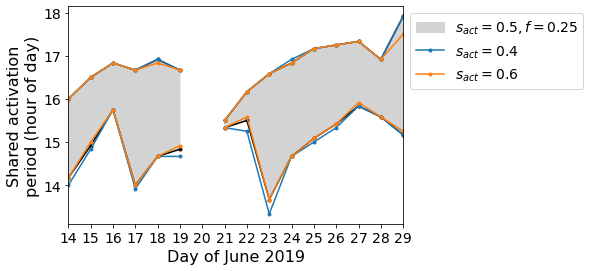

In [19]:
f,ax = plt.subplots(1,1)
f.set_size_inches(6,4)
a=ax
tpx = daynumstoshow
tpy = np.array(collectiveactivated).copy().astype(float)/12
tpy[tpy<0] = np.nan
a.plot(tpx,tpy[:,0],c='k',marker='.')
a.plot(tpx,tpy[:,1],c='k',marker='.')
a.fill_between(tpx,tpy[:,0],tpy[:,1],alpha=1,color='lightgrey',label="$s_{act}=0.5,f=0.25$")

params = [0.4,0.6]
for i in range(2):
    tpy = np.array(getcollact(collectivethreshold,params[i])).astype(float)/12
    tpy[tpy<0] = np.nan
    a.plot(tpx,tpy[:,0],c=bp.snscolors[i],marker='.', label='$s_{act}='+str(params[i])+'$')
    a.plot(tpx,tpy[:,1],c=bp.snscolors[i],marker='.')

a.set_xticks(tpx)
a.set_xticklabels(tpx+junedaynumoffset)
a.set_ylabel('Shared activation\nperiod (hour of day)',fontsize=16)

a.tick_params(labelsize=14)
a.set_xlim([9,24])
a.set_xlabel('Day of June 2019',fontsize=16)
a.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.savefig('image-output/collact-speed.pdf',bbox_inches='tight')
plt.show()

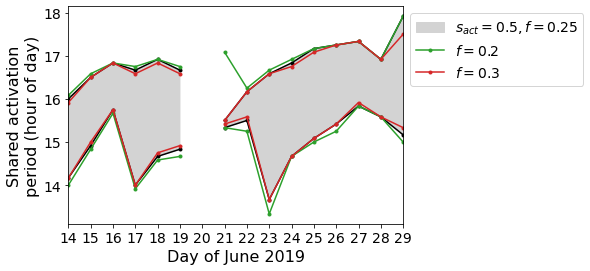

In [20]:
f,ax = plt.subplots(1,1)
f.set_size_inches(6,4)
a=ax
tpx = daynumstoshow
tpy = np.array(collectiveactivated).copy().astype(float)/12
tpy[tpy<0] = np.nan
a.plot(tpx,tpy[:,0],c='k',marker='.')
a.plot(tpx,tpy[:,1],c='k',marker='.')
a.fill_between(tpx,tpy[:,0],tpy[:,1],alpha=1,color='lightgrey',label="$s_{act}=0.5,f=0.25$")

params = [0.2,0.3]
for i in range(2):
    tpy = np.array(getcollact(params[i],speedthreshold)).astype(float)/12
    tpy[tpy<0] = np.nan
    a.plot(tpx,tpy[:,0],c=bp.snscolors[i+2],marker='.', label='$f='+str(params[i])+'$')
    a.plot(tpx,tpy[:,1],c=bp.snscolors[i+2],marker='.')

a.set_xticks(tpx)
a.set_xticklabels(tpx+junedaynumoffset)
a.set_ylabel('Shared activation\nperiod (hour of day)',fontsize=16)

a.tick_params(labelsize=14)
a.set_xlim([9,24])
a.set_xlabel('Day of June 2019',fontsize=16)
a.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.savefig('image-output/collact-frac.pdf',bbox_inches='tight')
plt.show()

## Per-bee quantitites for raster and activation order

In [21]:
daylist_speed = []
daylist_outside = []

for daynum in daynumstoshow:
    dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
    toplot_speed = dfdrones.pivot("Bee unique ID", 'timedivision', 'Median speed')
    daylist_speed.append(toplot_speed)
    toplot_outside = dfdrones.pivot("Bee unique ID", 'timedivision', 'Out of hive')
    daylist_outside.append(toplot_outside)

In [22]:
daylist_speed_workers = []
daylist_outside_workers = []

for daynum in daynumstoshow:
    dfworkers = df[((df['Cohort ID']==7)|(df['Cohort ID']==9))&(df['Day number']==daynum)]
    # this doesnt work to show all
#     dfworkers = df[np.logical_not(((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum))]
    toplot_speed = dfworkers.pivot("Bee unique ID", 'timedivision', 'Median speed')
    daylist_speed_workers.append(toplot_speed)
    toplot_outside = dfworkers.pivot("Bee unique ID", 'timedivision', 'Out of hive')
    daylist_outside_workers.append(toplot_outside)

In [23]:
# number of bees counted over time
def getnum(data):
    timebins = np.arange(numtimedivs*numdays+1)-0.5
    nums = scipy.stats.binned_statistic(data,np.ones(len(data)),bins=timebins,statistic=(lambda x: len(x)))[0] 
    nums[nums==0] = np.nan
    return nums

numbees_over_time = getnum(timedivs_all)
numdrones1_over_time = getnum(timedivs_all_drones1)
numdrones2_over_time = getnum(timedivs_all_drones2)
numworkers1_over_time = getnum(timedivs_all_workers1)
numworkers2_over_time = getnum(timedivs_all_workers2)

In [24]:
[daynumstoshow,collectiveactivated]

[array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
 [[-1, -1],
  [170, 192],
  [179, 198],
  [189, 202],
  [168, 200],
  [176, 203],
  [178, 200],
  [-1, -1],
  [184, 186],
  [186, 194],
  [164, 199],
  [176, 202],
  [181, 206],
  [185, 207],
  [190, 208],
  [187, 203],
  [182, 215]]]

# (Fig 1) Quantities over time

## General - multiple quantities

In [25]:
# how many unique IDs for all workers?
wdfsel = df[np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))]
print('number of unique bees included in all workers: ',len(np.unique(wdfsel['Bee unique ID'])))

number of unique bees included in all workers:  3246


In [26]:
# how many unique IDs for all workers?
wdfsel = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))]
print('number of unique drones included: ',len(np.unique(wdfsel['Bee unique ID'])))

number of unique drones included:  192


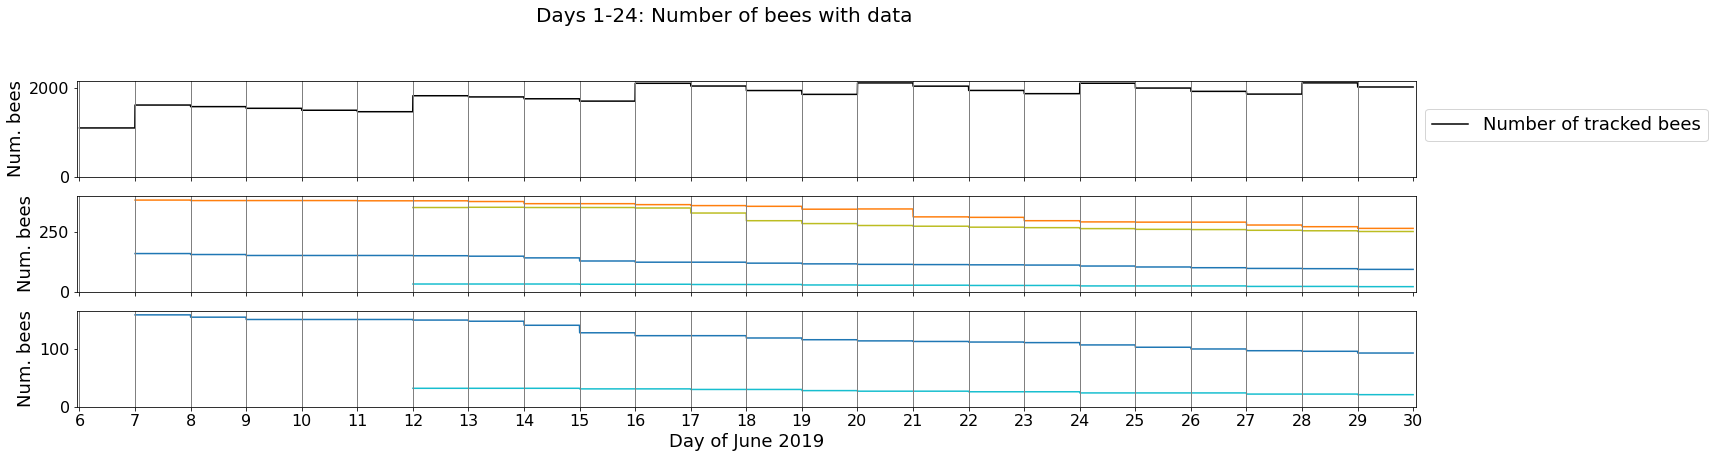

In [27]:


f,ax = plt.subplots(3,1,sharex=True,sharey=False)
f.set_size_inches(1*len(daystoload),2*3)

tpx = np.linspace(0,numdays,numtimedivs*numdays) + daystoload[0]

ax[0].plot(tpx,numbees_over_time,color='k',label='Number of tracked bees')
a=ax[1]
a.plot(tpx,numworkers1_over_time,color=workercolors[0],label='Workers in cohort 1')
a.plot(tpx,numworkers2_over_time,color=workercolors[1],label='Workers in cohort 2')    
for a in ax[1:3]:
    a.plot(tpx,numdrones1_over_time,color=dronecolors[0],label='Drones in cohort 1')
    a.plot(tpx,numdrones2_over_time,color=dronecolors[1],label='Drones in cohort 2')

for a in ax:
    a.set_ylabel('Num. bees',fontsize=18)
    a.set_ylim(bottom=0)
plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+": Number of bees with data",fontsize=20,y=1.05)

addlabels_and_formatting(ax)
plt.show()

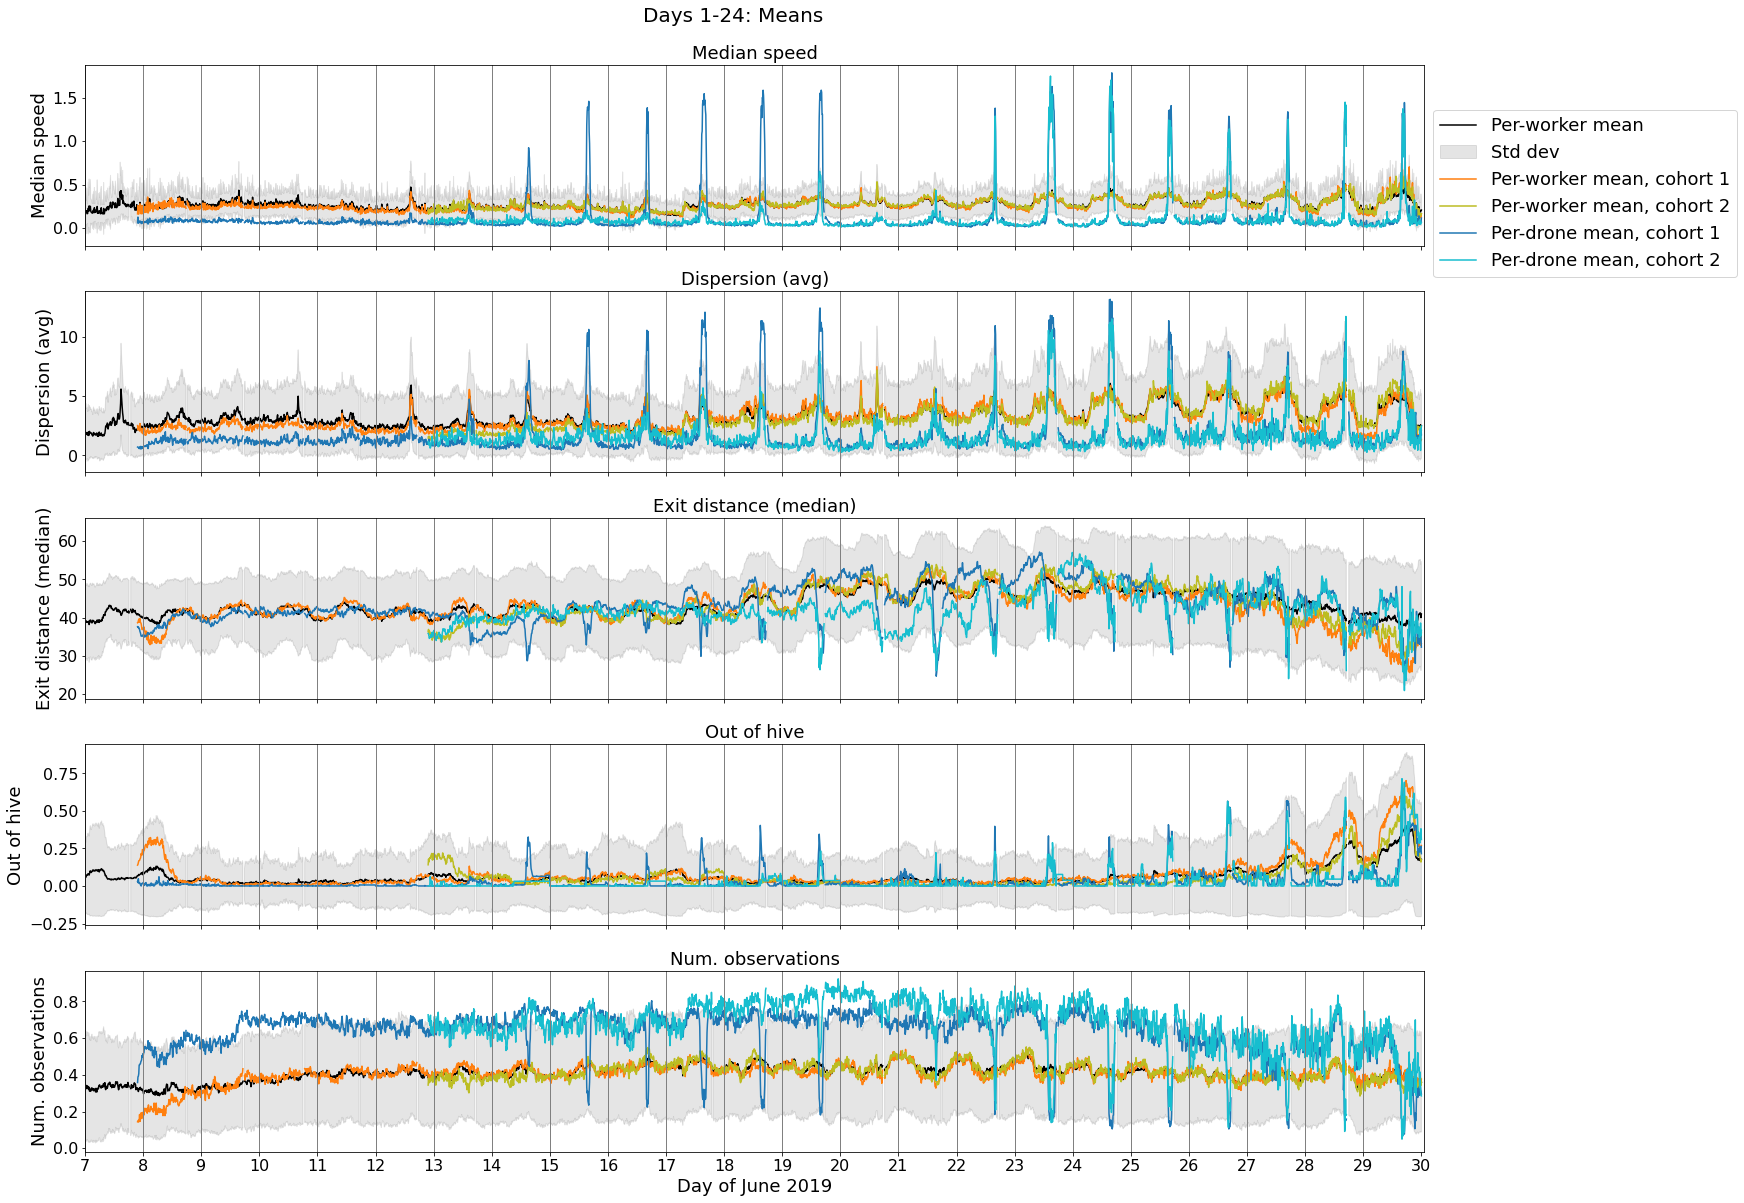

In [28]:
numev_toshow = numq
f,ax = plt.subplots(numev_toshow,1,sharex=True,sharey=False)
f.set_size_inches(1*len(daystoload),numev_toshow*4)

tpx = np.linspace(0,numdays,lx) + daystoload[0]

def getyerror(data):
    y = data[:,0]
    error = y-data[:,1], y+data[:,1]
    return y,error

for enum in range(numq):
    a = ax[enum]
    # all bees
    # y,error = getyerror(means_over_time[:,enum])
    # a.plot(tpx,y,color='k',label='Per-bee mean')
    # a.fill_between(tpx,error[0],error[1],color='k',alpha=0.1,label='Std dev')
    # all workers
    y,error = getyerror(means_over_time_allworkers[:,enum])
    a.plot(tpx,y,color='k',label='Per-worker mean')
    a.fill_between(tpx,error[0],error[1],color='k',alpha=0.1,label='Std dev')    
    # workers - 1
    y,error = getyerror(means_over_time_workers1[:,enum])
    a.plot(tpx,y,color=workercolors[0],label='Per-worker mean, cohort 1')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[2],alpha=0.1,label='Std dev')        
    # workers - 2
    y,error = getyerror(means_over_time_workers2[:,enum])
    a.plot(tpx,y,color=workercolors[1],label='Per-worker mean, cohort 2')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[3],alpha=0.1,label='Std dev')     
    # drones - 1
    y,error = getyerror(means_over_time_drones1[:,enum])
    a.plot(tpx,y,color=dronecolors[0],label='Per-drone mean, cohort 1')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[0],alpha=0.1,label='Std dev')    
    # drones - 2
    y,error = getyerror(means_over_time_drones2[:,enum])
    a.plot(tpx,y,color=dronecolors[1],label='Per-drone mean, cohort 2')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[1],alpha=0.1,label='Std dev')     
    # title, formatting
    a.set_title(datacolnames[enum],fontsize=18)
    a.set_ylabel(datacolnames[enum],fontsize=18)
plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+': Means',fontsize=20,y=0.92)
plt.subplots_adjust(hspace=0.25)
addlabels_and_formatting(ax)
ax[0].set_xlim(left=2)
plt.show()

## Specific quantities only (Fig 1)

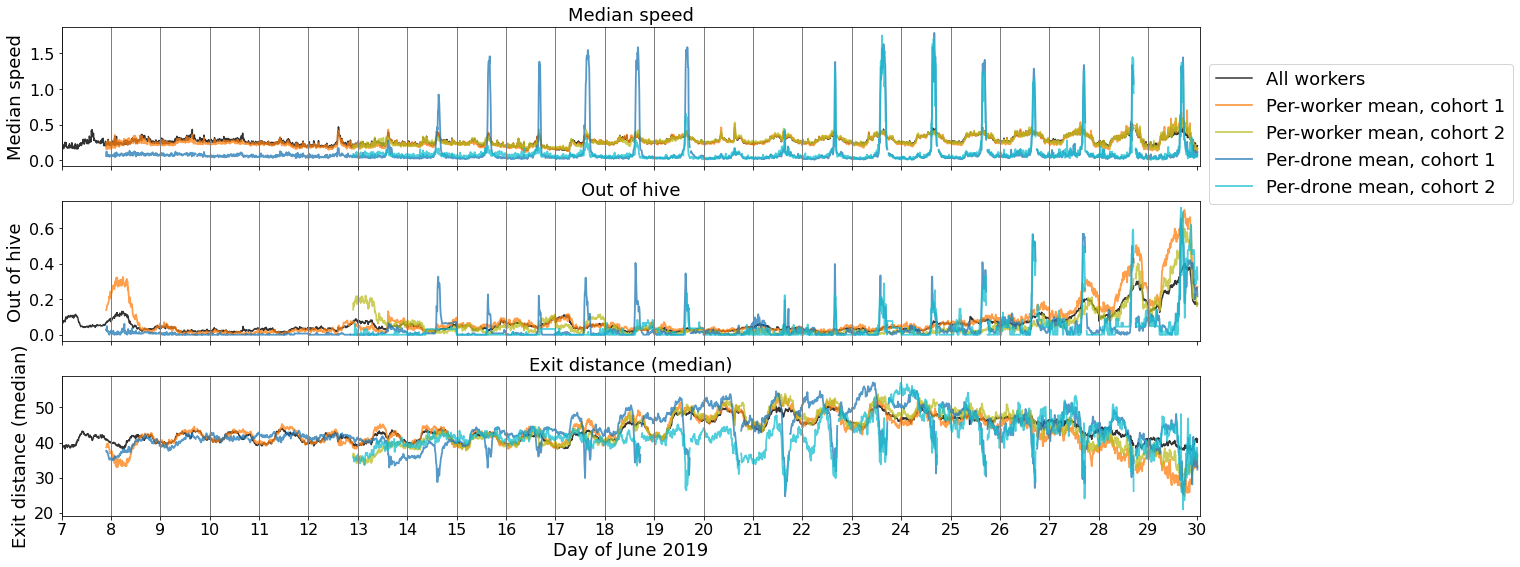

In [29]:
whichquantities = ['Median speed','Out of hive','Exit distance (median)']
focusindices = [np.where(np.array(datacolnames)==w)[0][0] for w in whichquantities]
focusindices


f,ax = plt.subplots(len(focusindices),1,sharex=True,sharey=False)
f.set_size_inches(0.85*len(daystoload),len(focusindices)*3)
alphaval=0.75
lw=1.8
tpx = np.linspace(0,numdays,lx) + daystoload[0]

def getyerror(data):
    y = data[:,0]
    error = y-data[:,1], y+data[:,1]
    return y,error

for i,enum in enumerate(focusindices):
    a = ax[i]
    # all bees or all workers
    y,error = getyerror(means_over_time_allworkers[:,enum])
    a.plot(tpx,y,color='k',label='All workers',alpha=0.8)
#     a.fill_between(tpx,error[0],error[1],color='k',alpha=0.1,label='Std dev')
    # workers - 1
    y,error = getyerror(means_over_time_workers1[:,enum])
    a.plot(tpx,y,color=workercolors[0],label='Per-worker mean, cohort 1',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[2],alpha=0.1,label='Std dev')        
    # workers - 2
    y,error = getyerror(means_over_time_workers2[:,enum])
    a.plot(tpx,y,color=workercolors[1],label='Per-worker mean, cohort 2',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[3],alpha=0.1,label='Std dev')     
    # drones - 1
    y,error = getyerror(means_over_time_drones1[:,enum])
    a.plot(tpx,y,color=dronecolors[0],label='Per-drone mean, cohort 1',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[0],alpha=0.1,label='Std dev')    
    # drones - 2
    y,error = getyerror(means_over_time_drones2[:,enum])
    a.plot(tpx,y,color=dronecolors[1],label='Per-drone mean, cohort 2',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[1],alpha=0.1,label='Std dev')     
    # title, formatting
    a.set_title(datacolnames[enum],fontsize=18)
    a.set_ylabel(datacolnames[enum],fontsize=18)
# plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+': Means',fontsize=20,y=0.92)
plt.subplots_adjust(hspace=0.25)
addlabels_and_formatting(ax)
ax[0].set_xlim(left=2)
plt.savefig('image-output/fig1temp'+str(exitdistthreshold)+'.pdf')
plt.show()

## Observation-weighted average (to compare calculations)

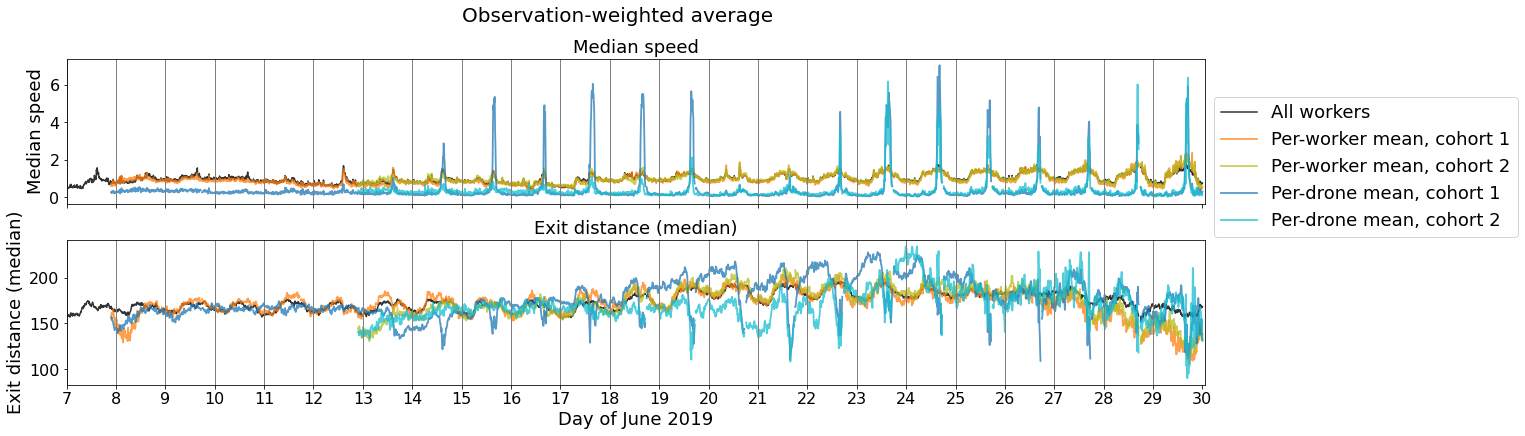

In [30]:
whichquantities = ['Median speed','Exit distance (median)']
focusindices = [np.where(np.array(datacolnames)==w)[0][0] for w in whichquantities]

f,ax = plt.subplots(len(focusindices),1,sharex=True,sharey=False)
f.set_size_inches(0.85*len(daystoload),len(focusindices)*3)
alphaval=0.75
lw=1.8
tpx = np.linspace(0,numdays,lx) + daystoload[0]

for i,enum in enumerate(focusindices):
    a = ax[i]
    # all bees or all workers
    y = obsmeans_over_time_allworkers[:,enum]
    a.plot(tpx,y,color='k',label='All workers',alpha=0.8)
#     a.fill_between(tpx,error[0],error[1],color='k',alpha=0.1,label='Std dev')
    # workers - 1
    y = obsmeans_over_time_workers1[:,enum]
    a.plot(tpx,y,color=workercolors[0],label='Per-worker mean, cohort 1',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[2],alpha=0.1,label='Std dev')        
    # workers - 2
    y = obsmeans_over_time_workers2[:,enum]
    a.plot(tpx,y,color=workercolors[1],label='Per-worker mean, cohort 2',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[3],alpha=0.1,label='Std dev')     
    # drones - 1
    y = obsmeans_over_time_drones1[:,enum]
    a.plot(tpx,y,color=dronecolors[0],label='Per-drone mean, cohort 1',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[0],alpha=0.1,label='Std dev')    
    # drones - 2
    y = obsmeans_over_time_drones2[:,enum]
    a.plot(tpx,y,color=dronecolors[1],label='Per-drone mean, cohort 2',alpha=alphaval,linewidth=lw)
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[1],alpha=0.1,label='Std dev')     
    # title, formatting
    a.set_title(datacolnames[enum],fontsize=18)
    a.set_ylabel(datacolnames[enum],fontsize=18)
plt.suptitle('Observation-weighted average',fontsize=20,y=1)
plt.subplots_adjust(hspace=0.25)
addlabels_and_formatting(ax)
ax[0].set_xlim(left=2)
plt.savefig('image-output/fig1-observation-weighted-average.pdf',bbox_inches='tight')
plt.savefig('image-output/fig1-observation-weighted-average.png',bbox_inches='tight')
plt.show()

In [31]:
start = np.where(weatherdata['timestamp']==bd.alldaytimestamps[daystoload[0]])[0][0]
end = start+(len(daystoload))*24
weather_per_hour = weatherdata[start:end][['Litzelstetten Temperature [2 m elevation corrected]','Litzelstetten Shortwave Radiation']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


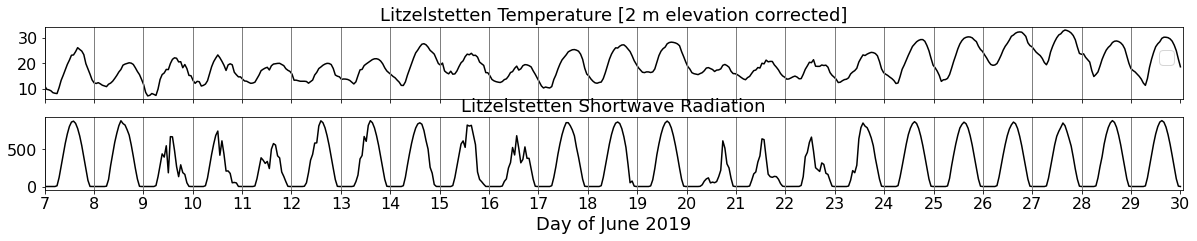

In [32]:
## weather data in the same way as above
f,ax = plt.subplots(weather_per_hour.shape[1],1,sharex=True,sharey=False)
f.set_size_inches(0.85*len(daystoload),len(ax)*1.5)

tpx = np.linspace(0,numdays,weather_per_hour.shape[0]) + daystoload[0]

for i,q in enumerate(weather_per_hour.columns):
    a = ax[i]
    # all bees or all workers
    a.plot(tpx,weather_per_hour[q],color='k',linewidth=1.5)
    # title, formatting
    a.set_title(q,fontsize=18)
    # a.set_ylabel(q[14:],fontsize=18)
# plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+': Means',fontsize=20,y=0.92)
plt.subplots_adjust(hspace=0.25)
addlabels_and_formatting(ax)
ax[0].set_xlim(left=2)
plt.savefig('image-output/fig1temp-weather.pdf')
plt.show()

# (Fig 2) Histograms

In [33]:
savefigures = False
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('image-output/'+'Fig1-B-hists.pdf')

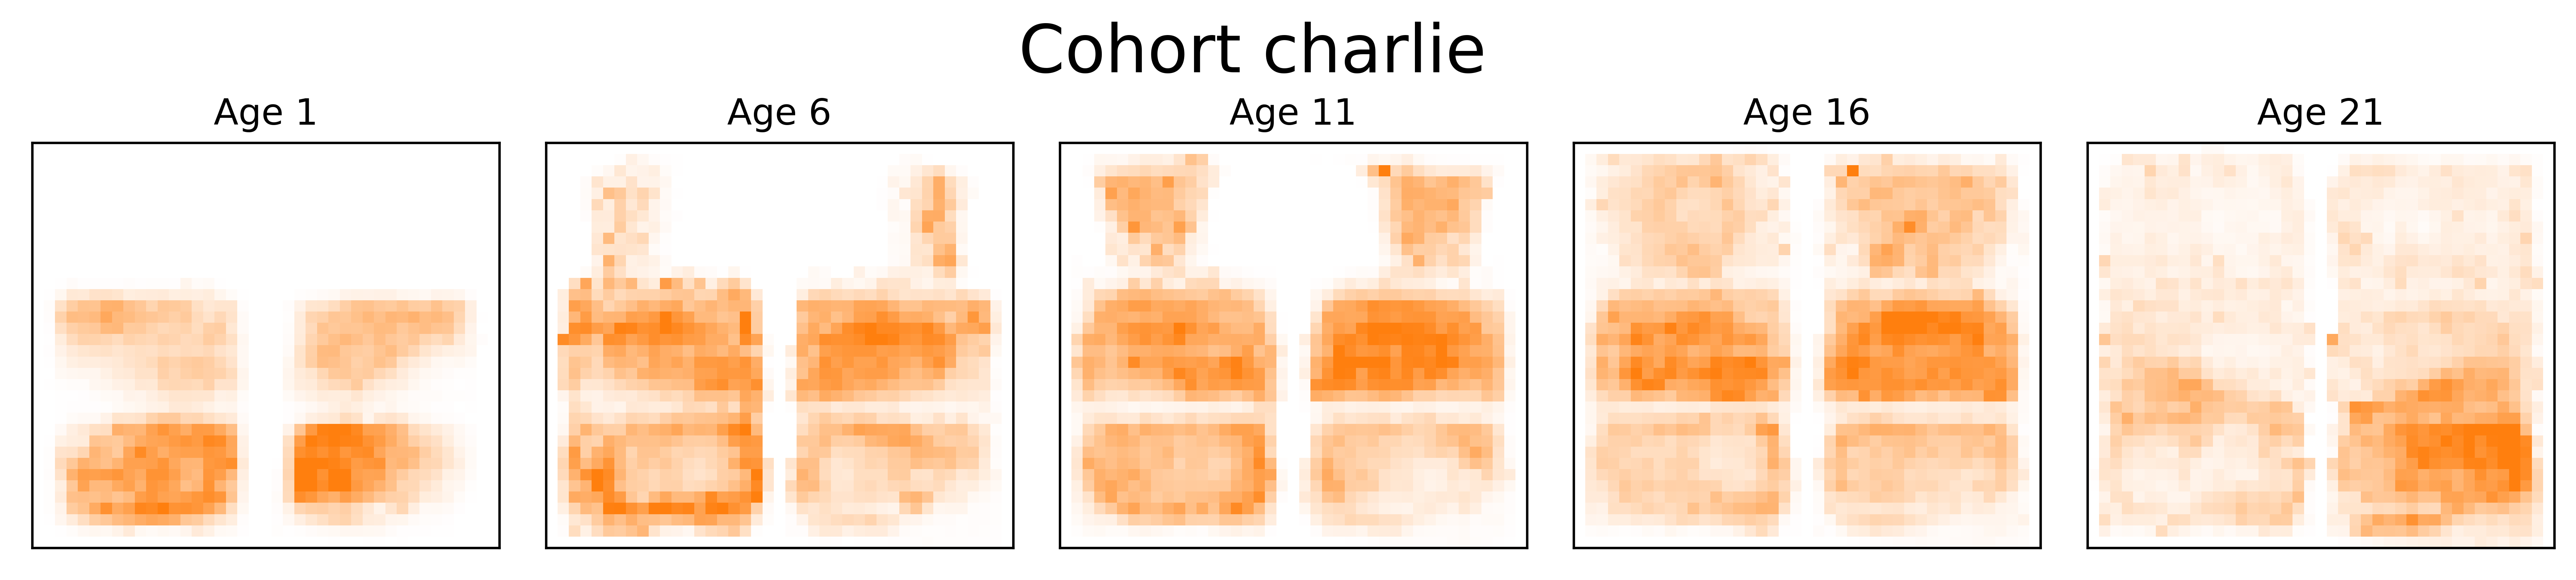

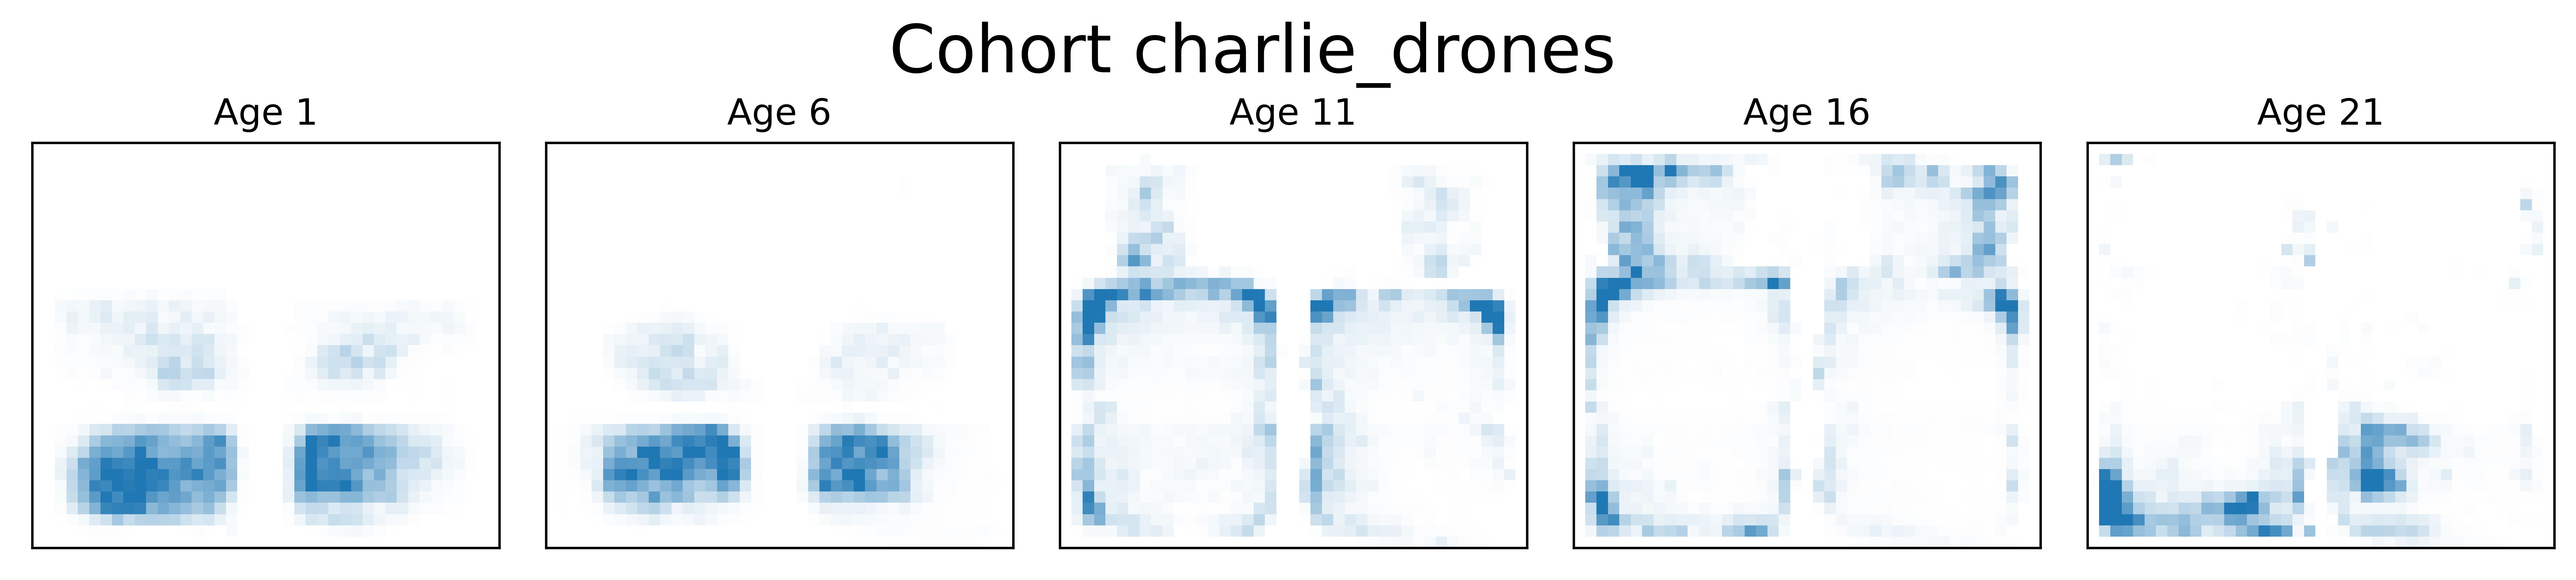

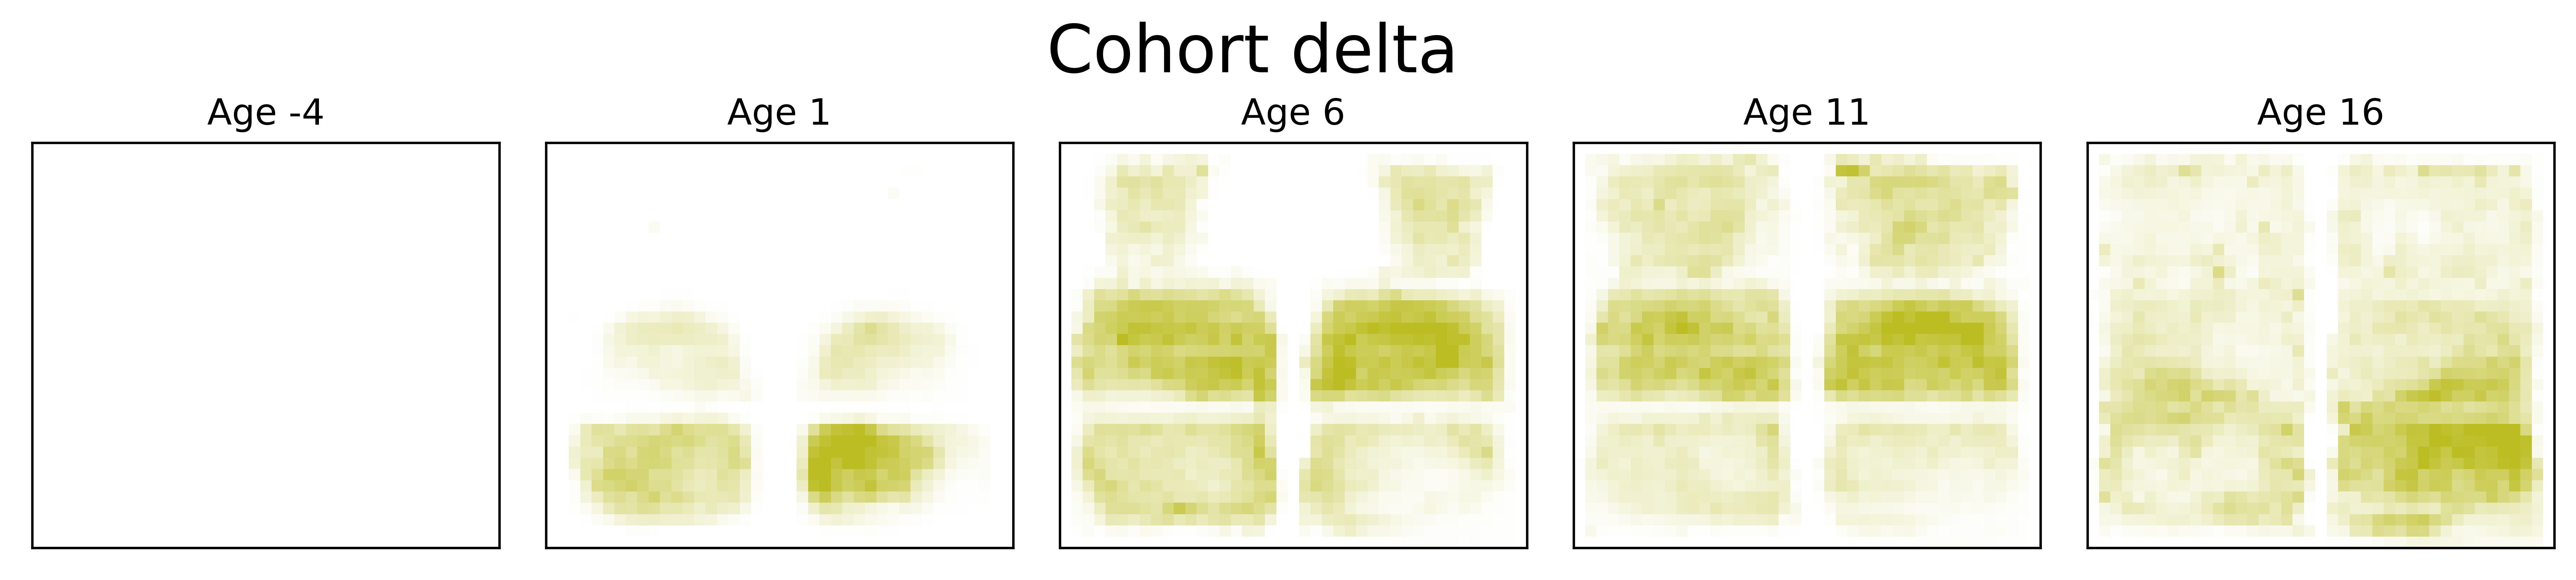

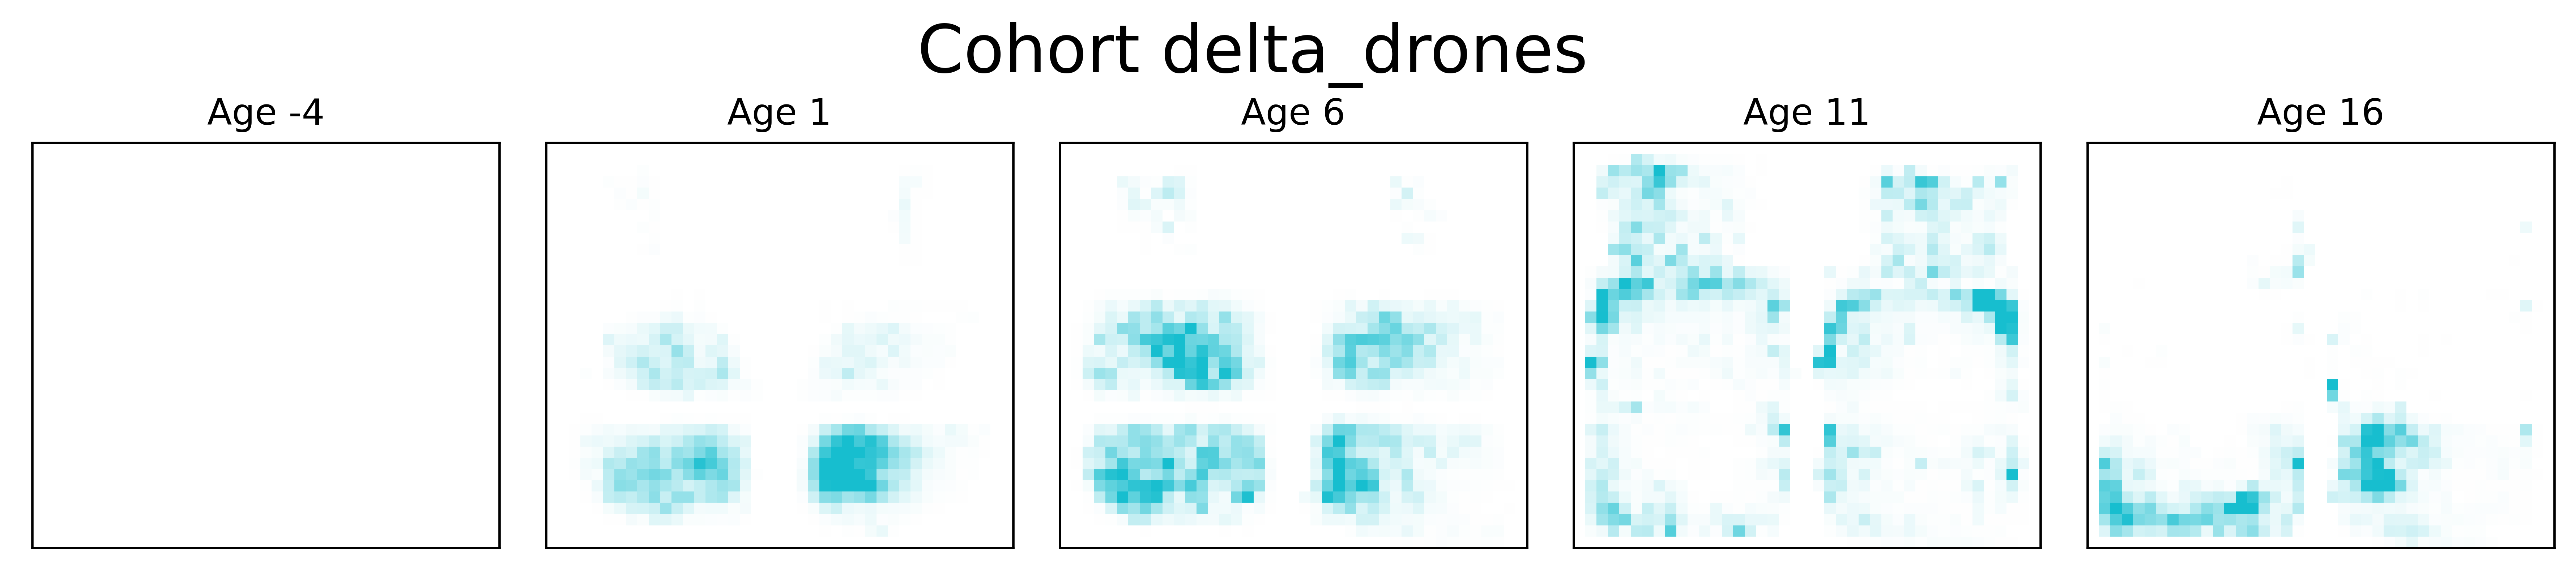

In [34]:
# Bees of a certain cohort, for each day loaded
cohortnum=8
tpcolors = [workercolors[0],dronecolors[0],workercolors[1],dronecolors[1]]
for cohortnum,color in zip([7,8,9,10],tpcolors):

    sel = (dfxy['Cohort ID']==cohortnum)
    bdaydaynum = np.where(bd.alldaytimestamps==bd.cohort_birthdates[cohortnum])[0][0]

    numcols = len(daystoloadxy)
    f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
    f.set_size_inches(numcols*3,3)
    f.set_dpi(600)
    f.set_facecolor('white')
    for i,daynum in enumerate(daystoloadxy):
        a=ax[i]
        dayhist = dfunc.flat_to_hist(np.mean(dfxy[sel & (dfxy['Day number']==daynum)],axis=0))
        bp.showhist(dayhist,ax=a,color=color)
        a.set_title('Age '+str(daynum-bdaydaynum))
    plt.suptitle('Cohort '+bd.cohort_names[cohortnum],fontsize=22,y=1)
    plt.subplots_adjust(wspace=0.1)
    pdf.savefig(f) if savefigures else None
    plt.show()


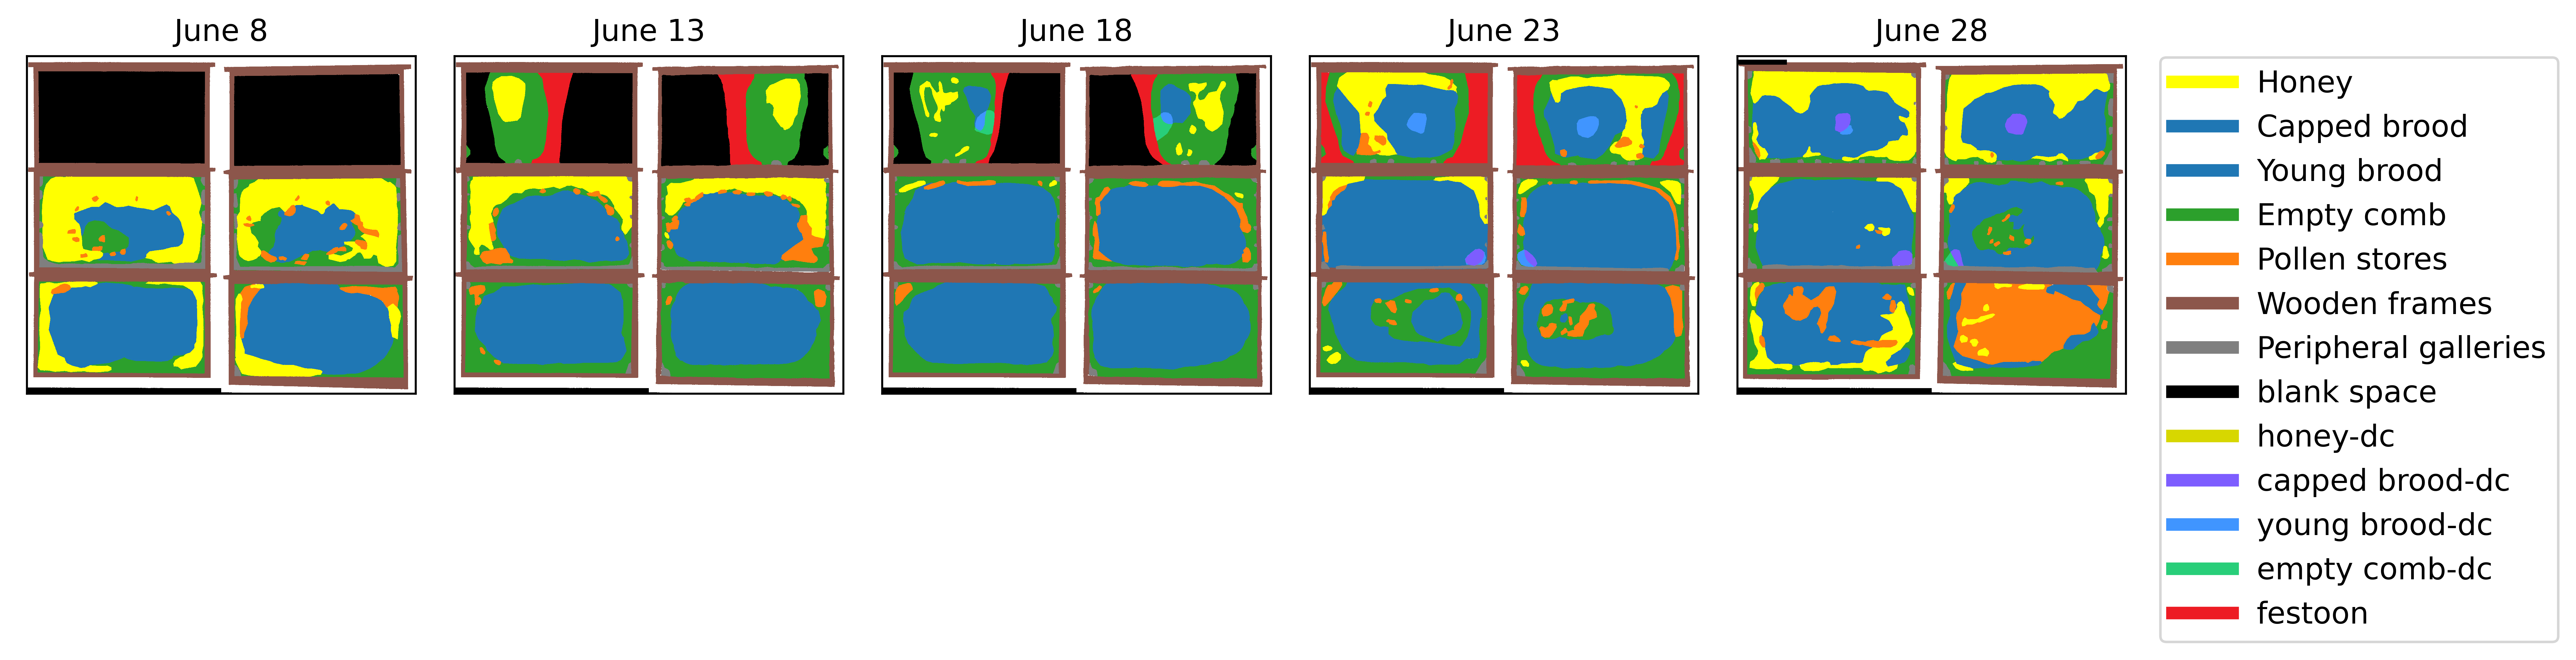

In [35]:
# plot all comb measurements along a line
numcols = len(daystoloadxy)
f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
f.set_size_inches(numcols*3,3)
f.set_dpi(600)
f.set_facecolor('white')
fontsize=12

# f,ax = plt.subplots(1,len(,sharex=True,sharey=True)
# basesize=10
# # fontsize=basesize*3
# f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0]*(bd.ypixels/(2*bd.xpixels)))

for i,daynum in enumerate(daystoloadxy):
    a=ax[i]
    bp.showcomb(allcomb[i],ax=a)
    a.set_title('June '+str(daynum+junedaynumoffset),fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)

# legend hack
a = ax[-1]
for i in range(len(bd.substrate_names)-1):
    if i==5:  # dance floor
#         a.plot(0,0,label='Dances observed',c=bd.cmap_comb(i),lw=5)
#         a.plot(0,0,label='Dance floor (combined)',linestyle='--',lw=5,c=bd.cmap_comb(i))        
        None
    else:
        a.plot(0,0,label=bd.substrate_names[i],c=bd.cmap_comb(i),lw=5)
a.legend(fontsize=fontsize,bbox_to_anchor=(1.05, 1.04))
linelength=10 # in cm
a.plot([0,0+linelength*bd.pixels_per_cm],[100,100],linewidth=2,color='k')
pdf.savefig(f) if savefigures else None
# plt.savefig('image-output/temp.pdf')
plt.show()


In [36]:
pdf.close() if savefigures else None
savefigures=False

# (Fig 3) Collection activation time and threshold

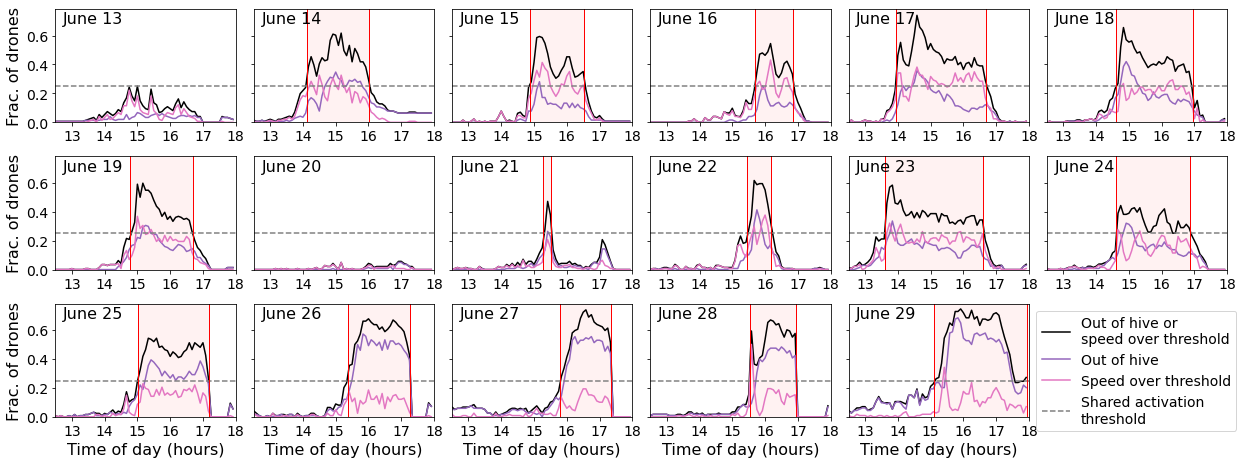

In [37]:
# Show all daynumstoshow.
numrows=3
numcols=np.ceil(len(daynumstoshow)/numrows).astype(int)

f,ax = plt.subplots(numrows,numcols,sharey=True,sharex='row')
f.set_size_inches(3.5*numcols,2.5*numrows)

daynum=21
for i,daynum in enumerate(daynumstoshow):
    r,c = np.divmod(i,numcols)
    a=ax[r,c]

    if daynum>=14:  # use both cohorts from this day on, because the younger cohort didn't really activate before this
        dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
    else:
        dfdrones = df[((df['Cohort ID']==8))&(df['Day number']==daynum)]

    speedvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Median speed').values[:,mindiv:maxdiv]
    outvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Out of hive').values[:,mindiv:maxdiv]

    activated = (speedvals>speedthreshold) | (outvals==1)
    groupactivated = np.mean(activated,axis=0)
    results = np.where(groupactivated>collectivethreshold)[0]

    tpx = (np.arange(len(groupactivated))+mindiv)/12
    a.plot(tpx,groupactivated,label='Out of hive or\nspeed over threshold',c='k')
    a.plot(tpx,np.mean(outvals==1,axis=0),label='Out of hive',linestyle='-',c=bp.snscolors[4])    
    a.plot(tpx,np.mean(speedvals>speedthreshold,axis=0),label='Speed over threshold',linestyle='-',c=bp.snscolors[6])
    
    a.axhline(collectivethreshold,linestyle='--',label='Shared activation\nthreshold',color='grey')
    
    if len(results)>0:
        act = np.array([results[0]+mindiv,results[-1]+mindiv])
        act = act/(numtimedivs)*24*287/288
        a.axvline(act[0],c='r',linewidth=1)
        a.axvline(act[1]+1/12,c='r',linewidth=1)
        a.axvspan(act[0],act[1]+1/12,color='r',alpha=0.05,zorder=-1)
    
    a.tick_params(labelsize=14)
    a.set_title('June '+str(daynum+junedaynumoffset),fontsize=16,x=0.21,y=0.82)
    a.set_xticks(np.arange(13,19))
    a.set_xlim([12.5,18])
    
[a.set_xlabel('Time of day (hours)',fontsize=16) for a in ax[-1]]


ax[0,0].set_ylim(bottom=0)    
ax[-1,-2].legend(fontsize=14,bbox_to_anchor=(1,1))    
ax[-1,-1].axis('off')
[a.set_ylabel('Frac. of drones',fontsize=16) for a in ax[:,0]]
plt.subplots_adjust(wspace=0.1,hspace=0.3)
plt.savefig('image-output/activation-definition-all.pdf')
plt.show()

# (Fig 3) Per-day averages lined up

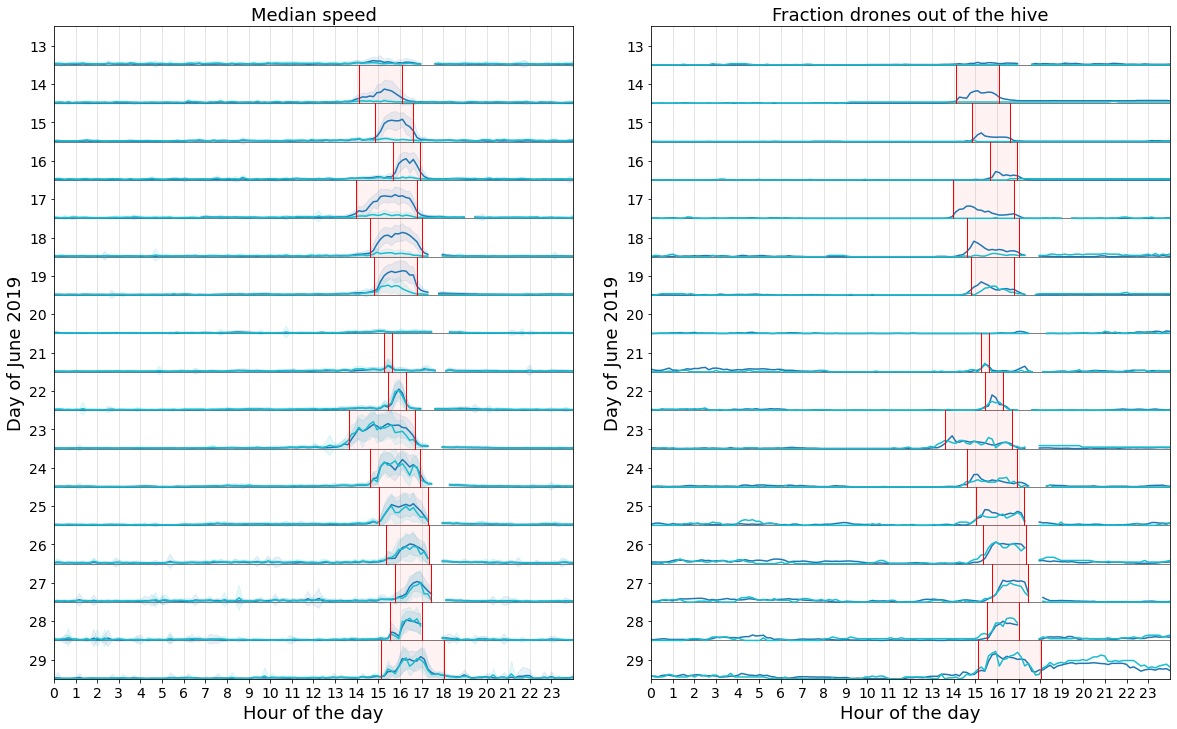

In [38]:
whichquantities = ['Median speed','Out of hive']
focusindices = [np.where(np.array(datacolnames)==w)[0][0] for w in whichquantities]
focusindices

tpx = np.linspace(0,24,int(numtimedivs/skip))

def setaxvals(a,yshifts):
    [a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
    a.set_xlim([0,24])
    a.tick_params(labelsize=14)
    a.set_xlim([0,24])
    #ticks
    a.set_xticks(np.arange(24))
    a.set_xticklabels(np.arange(24))
    a.set_yticks(np.array(yshifts)+yshift/2)
    a.set_yticklabels(daynumstoshow+junedaynumoffset)
    # title and labels
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)

    yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
    a.set_ylim([yshifts[-1],yshifts[0]])
    for i,act in enumerate(np.array(collectiveactivated)):
        ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
        act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
        if act[0]>0:
            a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
            a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
            a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)

f,ax=plt.subplots(1,2,sharex=True,sharey=False)
f.set_size_inches(20,12)

# Median speed
k=0
enum=focusindices[k]
a=ax[k]
selind = [0,2][k]
y1_perday = np.reshape(means_over_time_drones1[:,enum,selind],(-1,len(tpx)))
ystd1_perday = np.reshape(means_over_time_drones1[:,enum,1],(-1,len(tpx)))
y2_perday = np.reshape(means_over_time_drones2[:,enum,selind],(-1,len(tpx)))
ystd2_perday = np.reshape(means_over_time_drones2[:,enum,1],(-1,len(tpx)))
y_perday = y1_perday+y2_perday
yshift = 2.5

yshifts=[]
for daynum in daynumstoshow:
    i = np.where(daynum==daystoload)[0][0]
    offset=yshift*(24-i-1)
    yshifts.append(offset)
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    for y_perday,ystd_perday,color in zip([y1_perday,y2_perday],[ystd1_perday,ystd2_perday],dronecolors):
        a.plot(tpx,y_perday[i]+offset,c=color)
        a.fill_between(tpx,offset+y_perday[i]+ystd_perday[i],offset+y_perday[i]-ystd_perday[i],color=color,alpha=0.1)     
a.set_title(datacolnames[enum],fontsize=18)    
setaxvals(a,yshifts)

# Fraction out of hive
k=1
enum=focusindices[k]
a=ax[k]
selind = [0,2][k]
y1_perday = np.reshape(means_over_time_drones1[:,enum,selind]/numdrones1_over_time[::skip],(-1,len(tpx)))
y2_perday = np.reshape(means_over_time_drones2[:,enum,selind]/numdrones2_over_time[::skip],(-1,len(tpx)))
y_perday = y1_perday+y2_perday
# yshift = np.nanmax([y1_perday,y2_perday])*1.1
yshift=1

yshifts=[]
for daynum in daynumstoshow:
    i = np.where(daynum==daystoload)[0][0]
    offset=yshift*(24-i-1)
    yshifts.append(offset)
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    for y_perday,ystd_perday,color in zip([y1_perday,y2_perday],[ystd1_perday,ystd2_perday],dronecolors):
        a.plot(tpx,y_perday[i]+offset,c=color)
#             a.fill_between(tpx,offset+y_perday[i]+ystd_perday[i],offset+y_perday[i]-ystd_perday[i],color=color,alpha=0.1)     
a.set_title(datacolnames[enum],fontsize=18)     
setaxvals(a,yshifts)



            
ax[1].set_title('Fraction drones out of the hive',fontsize=18)          
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/Hourly-lined-up'+str(exitdistthreshold)+'.pdf')
plt.show()

# (Fig 4) Individuals raster plot

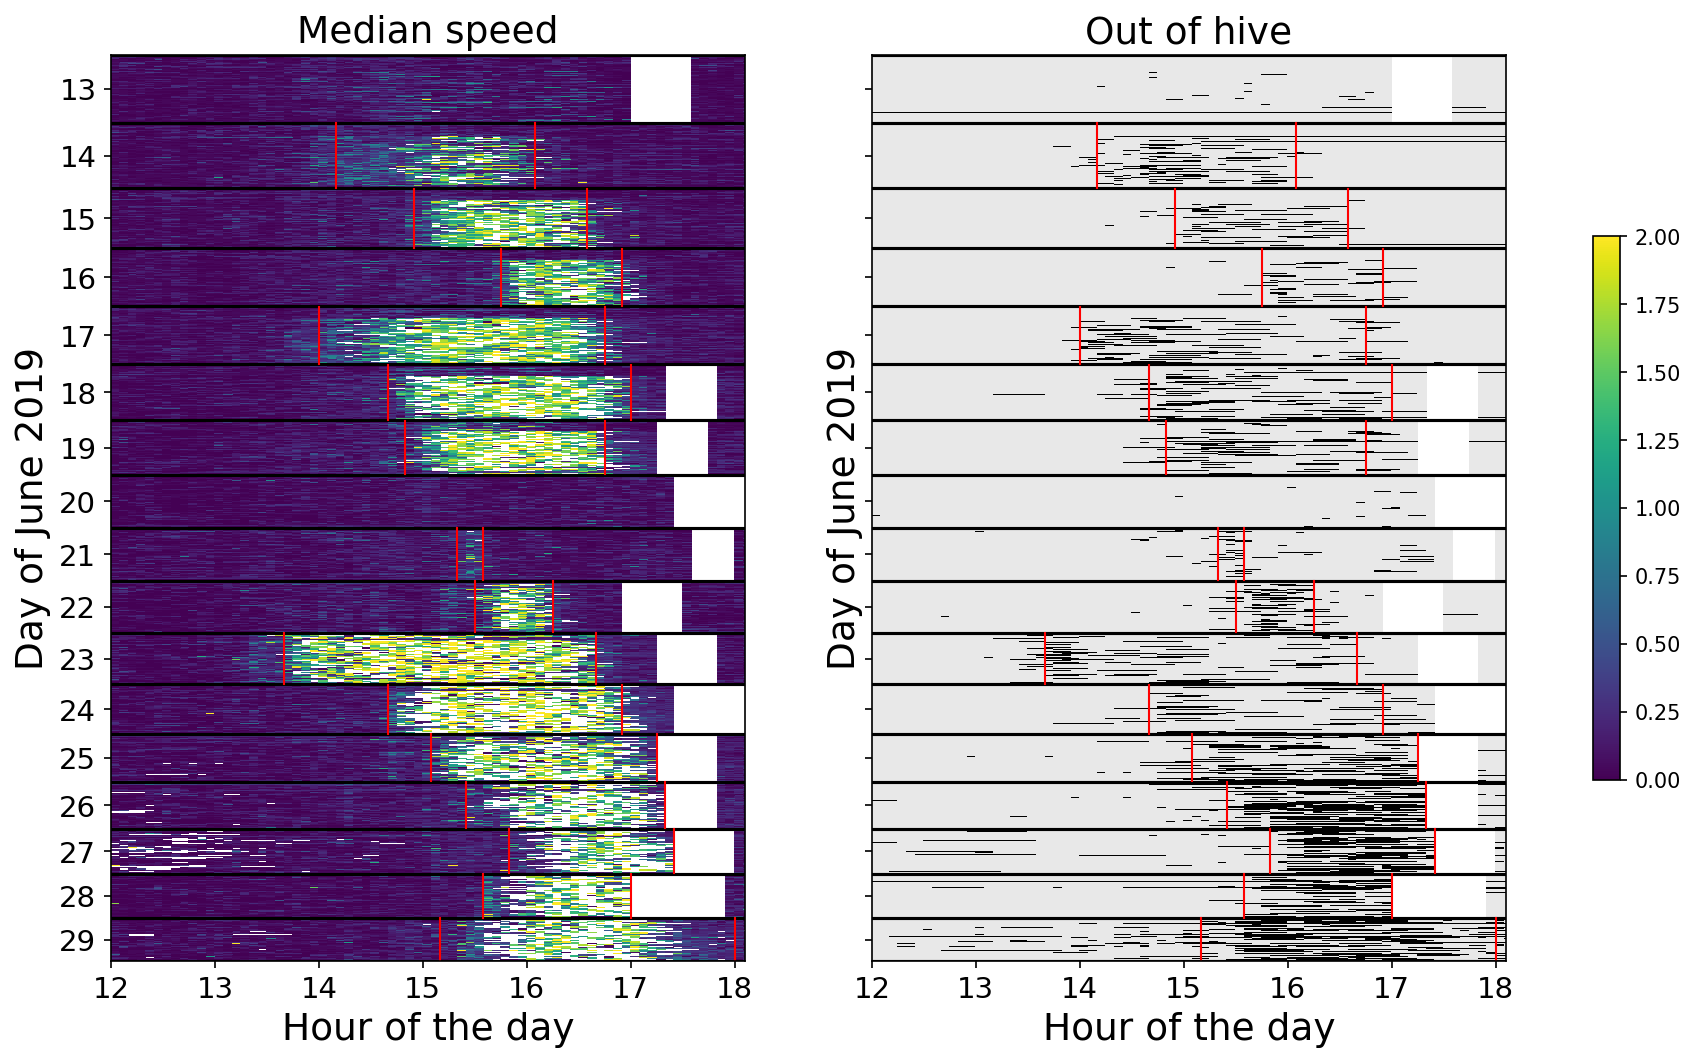

In [39]:
f,ax = plt.subplots(1,2,sharex=True,sharey='row')
f.set_size_inches(15,8)

a=ax[0]
pc = a.pcolor(np.vstack(daylist_speed[::-1]), cmap='viridis',vmax=2,rasterized=True)
f.colorbar(pc, ax=ax,shrink=0.6)
a.set_title('Median speed',fontsize=18)

a=ax[1]
a.pcolor(np.vstack(daylist_outside[::-1]), cmap='binary',vmax=1,vmin=-0.1,rasterized=True)
a.set_title('Out of hive',fontsize=18)               

for a in ax:
    divisions = np.insert(np.cumsum(np.flip([x.shape[0] for x in daylist_speed])),0,0)
    [a.axhline(d,c='k') for d in divisions]
    yticks = (divisions[1:]+divisions[:-1])/2
    a.set_yticks(yticks)
    a.set_yticklabels(np.flip(daynumstoshow)+junedaynumoffset)

    a.set_xticks(np.arange(24)*12)
    a.set_xticklabels(np.arange(24))
    # title and labels
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)
    a.tick_params(labelsize=14)
    a.set_xlim(np.array([12,18.1])*12)

    for i,act in enumerate(np.flipud(collectiveactivated)):
        ymin, ymax = (divisions[i]+1)/divisions[-1], (divisions[i+1]-1)/divisions[-1]
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+1,c='r',ymin=ymin,ymax=ymax,linewidth=1)


### used this one for final figure, the colors are easier to see
f.set_dpi(150)
plt.savefig('image-output/raster150.pdf')
plt.show()

In [40]:
xcomp = np.vstack(daylist_speed[::-1])

## Workers raster plot

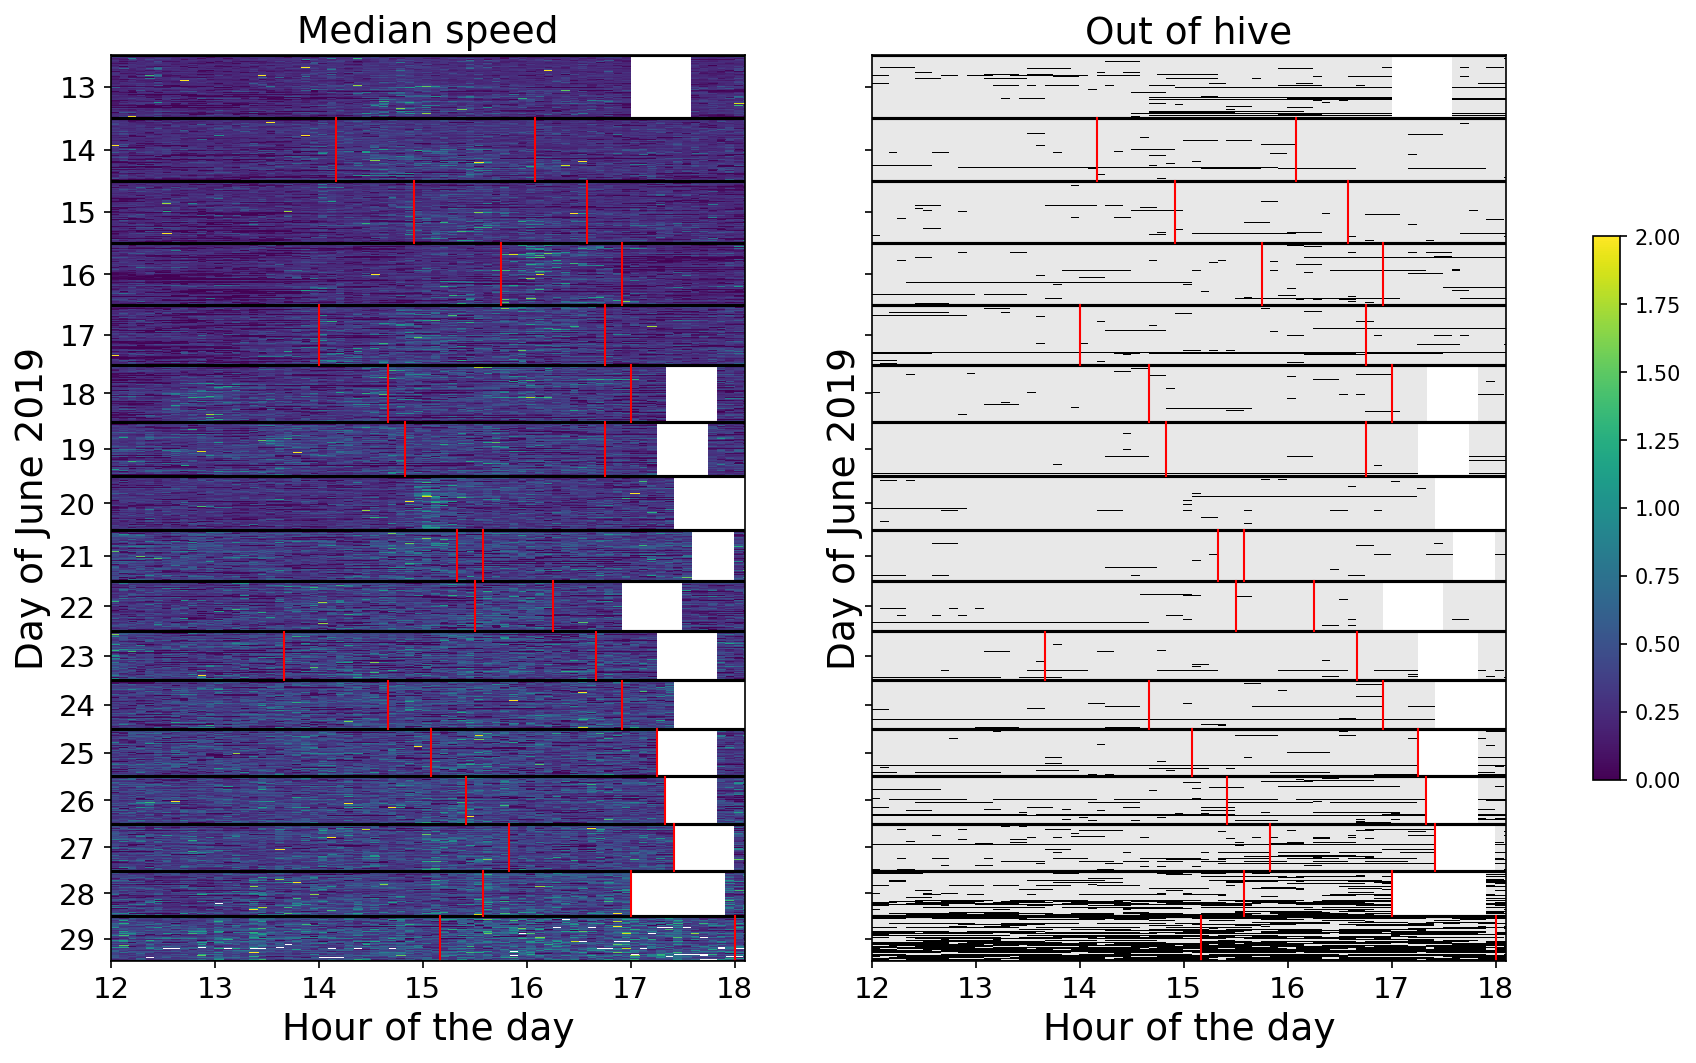

In [41]:
f,ax = plt.subplots(1,2,sharex=True,sharey='row')
f.set_size_inches(15,8)
a=ax[0]
pc = a.pcolor(np.vstack(daylist_speed_workers[::-1]), cmap='viridis',vmax=2,rasterized=True)
f.colorbar(pc, ax=ax,shrink=0.6)
a.set_title('Median speed',fontsize=18)

a=ax[1]
a.pcolor(np.vstack(daylist_outside_workers[::-1]), cmap='binary',vmax=1,vmin=-0.1,rasterized=True)
a.set_title('Out of hive',fontsize=18)               

for a in ax:
    divisions = np.insert(np.cumsum(np.flip([x.shape[0] for x in daylist_speed_workers])),0,0)
    [a.axhline(d,c='k') for d in divisions]
    yticks = (divisions[1:]+divisions[:-1])/2
    a.set_yticks(yticks)
    a.set_yticklabels(np.flip(daynumstoshow)+junedaynumoffset)

    a.set_xticks(np.arange(24)*12)
    a.set_xticklabels(np.arange(24))
    # title and labels
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)
    a.tick_params(labelsize=14)
    a.set_xlim(np.array([12,18.1])*12)

    for i,act in enumerate(np.flipud(collectiveactivated)):
        ymin, ymax = (divisions[i]+1)/divisions[-1], (divisions[i+1]-1)/divisions[-1]
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+1,c='r',ymin=ymin,ymax=ymax,linewidth=1)


f.set_dpi(150)
plt.savefig('image-output/raster150-focus-workers.pdf')
plt.show()

# (Fig 5) - Activation order

## Activation order and correlation

In [42]:
all_indfirstacts = []
all_indfirstacts_speed = []
all_indfirstacts_outside = []
all_uids = []
for i,daynum in enumerate(daynumstoshow):
    actstart, actend = collectiveactivated[i]
    dayspeed = daylist_speed[i].values
    dayout = daylist_outside[i].values

    backdivs=12

    indfirstacts = np.tile(-1,dayout.shape[0])
    indfirstacts_speed = np.tile(-1,dayout.shape[0])
    indfirstacts_outside = np.tile(-1,dayout.shape[0])    
    for j in range(len(dayout)):
        jact = np.where((dayspeed[j][actstart-backdivs:actend+1]>speedthreshold)|(dayout[j][actstart-backdivs:actend+1]==1))[0]
        jact_speed = np.where((dayspeed[j][actstart-backdivs:actend+1]>speedthreshold))[0]
        jact_outside = np.where((dayout[j][actstart-backdivs:actend+1]==1))[0]
        # if jact=0, then they activate at actstart-backdivs.  If jact=backdivs, then at the collective act time.
        # if jact>backdivs, then after the collective activation time.  The maximum is then backdivs+collective act time.
        if len(jact)>0:
            indfirstacts[j]=jact[0]
        if len(jact_speed)>0:
            indfirstacts_speed[j]=jact_speed[0]
        if len(jact_outside)>0:
            indfirstacts_outside[j]=jact_outside[0]            
    
    all_indfirstacts.append(indfirstacts)
    all_indfirstacts_speed.append(indfirstacts_speed)
    all_indfirstacts_outside.append(indfirstacts_outside)
    all_uids.append(daylist_speed[i].index)


In [43]:
# -1 means was never activated on that day, nan means dead
dfact = pd.DataFrame(index=np.unique(np.concatenate(all_uids)))
for u,i,i_spd,i_out,daynum in zip(all_uids,all_indfirstacts,all_indfirstacts_speed,all_indfirstacts_outside,daynumstoshow):
    dfact.loc[u,daynum] = i
    dfact.loc[u,str(daynum)+'-spd'] = i_spd
    dfact.loc[u,str(daynum)+'-out'] = i_out

In [44]:
allcorr = np.tile(np.nan,len(daynumstoshow)-1)
allcorr_spear = np.tile(np.nan,len(daynumstoshow)-1)
for i,daynum in enumerate(daynumstoshow[:-1]):
    x,y = dfact[daynum],dfact[daynum+1]
    sel = (x>=0)&(y>=0)&np.logical_not(np.isnan(x))&np.logical_not(np.isnan(y))
    if np.sum(sel)>=2:
        allcorr[i] = scipy.stats.pearsonr(x[sel],y[sel])[0]
        allcorr_spear[i] = scipy.stats.spearmanr(x[sel],y[sel])[0]

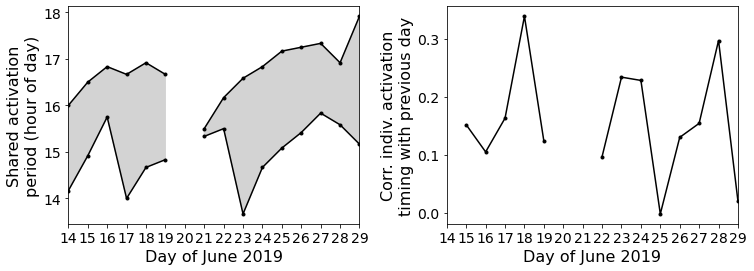

In [45]:
f,ax = plt.subplots(1,2)
f.set_size_inches(12,4)
a=ax[0]
tpx = daynumstoshow
tpy = np.array(collectiveactivated).copy().astype(float)/12
tpy[tpy<0] = np.nan
a.plot(tpx,tpy[:,0],c='k',marker='.')
a.plot(tpx,tpy[:,1],c='k',marker='.')
a.fill_between(tpx,tpy[:,0],tpy[:,1],alpha=1,color='lightgrey')
a.set_xticks(tpx)
a.set_xticklabels(tpx+junedaynumoffset)
a.set_ylabel('Shared activation\nperiod (hour of day)',fontsize=16)
a=ax[1]
tpx = daynumstoshow[:-1]+1
a.plot(tpx,allcorr,c='k',marker='.')
# a.plot(tpx,allcorr_spear,c='r')
a.set_ylabel('Corr. indiv. activation\ntiming with previous day',fontsize=16)
a.set_xticks(tpx)
a.set_xticklabels(tpx+junedaynumoffset)

for a in ax:
    a.tick_params(labelsize=14)
    a.set_xlim([9,24])
    a.set_xlabel('Day of June 2019',fontsize=16)
    
plt.subplots_adjust(wspace=0.3)
# plt.savefig('image-output/activation.pdf')
plt.show()



## Speed preceding before went outside (at beginning/before activation period)
An individuals first time outside can be before the start of the collective activation period, because of course it has to so, per the definitions.  See 'backdivs' - this how long before the start of the coll act period, to consider this

In [46]:
# per day
back_for_averaging = 12
all_speeds_before_first_exit = []
for i,daynum in enumerate(daynumstoshow):
    actstart, actend = collectiveactivated[i]    
    vals = []
    sel = all_indfirstacts_outside[i]>0
    firstout = (actstart-backdivs + all_indfirstacts_outside[i])[sel]
    for f_ind, spd in zip(firstout,daylist_speed[i][sel].values):
        vals.append(spd[f_ind-back_for_averaging:f_ind])    
        # break
    if len(vals)>0:
        vals = np.vstack(vals)
    all_speeds_before_first_exit.append(vals)

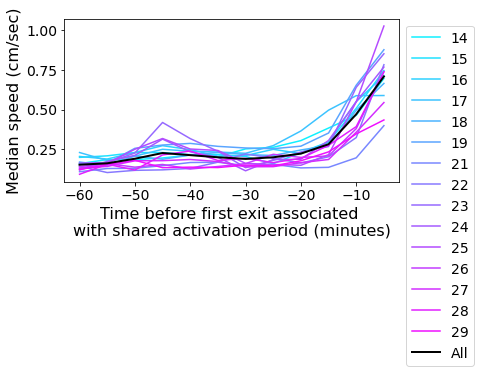

In [47]:
f,ax=plt.subplots(1,1)
f.set_size_inches(6,3)
tpx = np.arange(-back_for_averaging,0)*5
cmapcool=plt.get_cmap('cool')
actdays = (np.array(collectiveactivated)[:,0]>0)
for i,x in enumerate(all_speeds_before_first_exit):
    if len(x)>0:
        tp = np.nanmean(x,axis=0)
        ax.plot(tpx,tp,label=daynumstoshow[i]+junedaynumoffset,c=cmapcool(i/len(all_speeds_before_first_exit)))
tp = np.nanmean(np.vstack(list(itertools.compress(all_speeds_before_first_exit,actdays))),axis=0)  # the itertools code does masking of a list
ax.plot(tpx,tp,label='All',c='k',linewidth=2)
ax.legend(bbox_to_anchor=[1,1],fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylabel('Median speed (cm/sec)',fontsize=16)
ax.set_xlabel('Time before first exit associated \nwith shared activation period (minutes)',fontsize=16)
plt.savefig('image-output/pre-speed.pdf',bbox_inches="tight")
plt.show()

## Activation order relationship with other quantities

In [48]:
divsperhour = 12
starttimediv, endtimediv = 0*divsperhour, 12*divsperhour

# add other metrics to dfact, so can compare them to the activation time
# keeping the morning period
i=2
metrics_tocompare = ['Exit distance (median)','Median speed']
all_dftocompare = []
for i, daynum in enumerate(daynumstoshow):
    uids = all_uids[i]
    # use both drone cohorts, because they are both included in activation order and correlation.  Just for def of "collective activation period" its selective
    dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
    dfdrones = dfdrones[(dfdrones['timedivision']>=starttimediv)&(dfdrones['timedivision']<endtimediv)]  # just keep the "morning", for averaging

    gb = dfdrones.groupby('Bee unique ID')[metrics_tocompare].mean()
    gb = gb.merge(dfact[[daynum,str(daynum)+'-spd',str(daynum)+'-out']],left_on='Bee unique ID',right_on=dfact.index)
    gb.rename(columns={(daynum):'Relative Activation Time'},inplace=True)
    gb.rename(columns={str(daynum)+'-spd':'Relative Activation Time-Speed'},inplace=True)    
    gb.rename(columns={str(daynum)+'-out':'Relative Activation Time-Outside'},inplace=True)        
    # add ranked-order for each metric
    for m in metrics_tocompare:
        gb[m+'-order'] = np.argsort(np.argsort(gb[m]))
    all_dftocompare.append(gb)

METRIC POSTFIX: -order


Text(0.5, 1.03, 'Correlation values for each day')

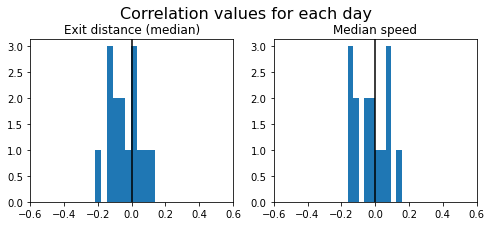

In [49]:
# calculate and make per-day correlation plots
makecorrplots=False

metricpostfix = ['','-order'][1]  # use 1 or ordering
print('METRIC POSTFIX:',metricpostfix)

if makecorrplots:
    f,ax = plt.subplots(len(metrics_tocompare),len(daynumstoshow))
    f.set_size_inches(ax.shape[1]*4,ax.shape[0]*3)
corr_dm = np.tile(np.nan,(len(daynumstoshow),len(metrics_tocompare)))
for i,daynum in enumerate(daynumstoshow):
    for j,m in enumerate(metrics_tocompare):
        if makecorrplots:
            a=ax[j,i]
        x = all_dftocompare[i]['Relative Activation Time']
        y = all_dftocompare[i][m+metricpostfix]
        sel = (x>=0) & np.logical_not(np.isnan(y))
        if np.sum(sel)>2:
            corr = scipy.stats.pearsonr(x[sel],y[sel])[0]
            corr_dm[i,j] = corr
            if makecorrplots:
                sns.regplot(x=x[sel],y=y[sel],ax=a)
                a.set_title(np.round(corr,3),y=0.9)

f,ax = plt.subplots(1,len(metrics_tocompare),sharex=True)
f.set_size_inches(len(ax)*4,3)
for j,m in enumerate(metrics_tocompare):
    a=ax[j]
    a.hist(corr_dm[:,j])
    a.set_title(m)
    a.axvline(0,c='k')
    a.set_xlim([-0.6,0.6])
plt.suptitle('Correlation values for each day',y=1.03,fontsize=16)

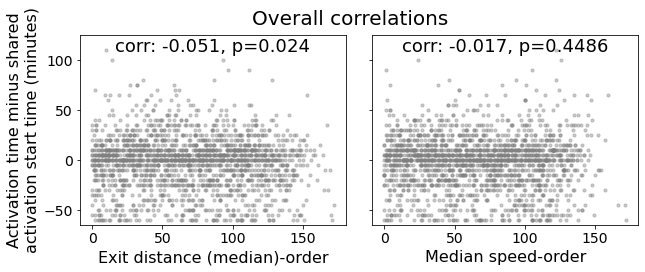

In [50]:
postfix = ''  # or '-Speed','-Outside', to look just at speed activation or going outside

f,ax = plt.subplots(1,len(metrics_tocompare),sharey=True)
f.set_size_inches(len(ax)*5,3.5)
for j,m in enumerate(metrics_tocompare):
    a=ax[j]
    tpx = np.array([])
    tpy = np.array([])
    for i,daynum in enumerate(daynumstoshow):
        x = all_dftocompare[i][m+metricpostfix]
        y = all_dftocompare[i]['Relative Activation Time'+postfix]        
        sel = (y>=0) & np.logical_not(np.isnan(x))
        tpx = np.concatenate((tpx,x[sel]))
        tpy = np.concatenate((tpy,y[sel]))

    corr, pvalue = scipy.stats.pearsonr(tpx,tpy)
    
    a.scatter(tpx,(tpy-backdivs)*5,alpha=0.4,s=10,c='grey',rasterized=True)
    a.set_title('corr: '+str(np.round(corr,3))+', p='+str(np.round(pvalue,4)),y=0.88,fontsize=18)
    a.set_xlabel(m+metricpostfix,fontsize=16)
    a.tick_params(labelsize=14)
    a.set_ylim([-65,125])
    # a.axhline(0,c='grey',label='Shared activation time')
ax[0].set_ylabel('Activation time minus shared\nactivation start time (minutes)',fontsize=16)    
plt.suptitle('Overall correlations'+postfix,fontsize=20)
plt.subplots_adjust(wspace=0.1)
# plt.savefig('image-output/order-corr-metricsorder.pdf',dpi=600)
plt.show()

# (Fig 3+Supp) Weather comparison

In [51]:
start = np.where(weatherdata['timestamp']==bd.alldaytimestamps[daystoload[0]])[0][0]
end = start+(len(daystoload)+1)*24
weather_per_hour = weatherdata[start:end][['Litzelstetten Temperature [2 m elevation corrected]','Litzelstetten Shortwave Radiation',
                                           'Litzelstetten Vapor Pressure Deficit [2 m]','Litzelstetten Wind Speed [10 m]']]

In [52]:
# take per-day averages to use below
start = np.where(weatherdata['timestamp']==bd.alldaytimestamps[daystoload[0]])[0][0]
end = start+(len(daystoload)+1)*24
qnamestoaverage = ['Litzelstetten Mean Sea Level Pressure [MSL]','Litzelstetten Wind Speed [10 m]', 'Litzelstetten Vapor Pressure Deficit [2 m]']
weather_per_hour_averaged = [np.mean(np.reshape(weatherdata[start:end][[q]].values,(len(daystoload)+1,24)),axis=1) for q in qnamestoaverage]


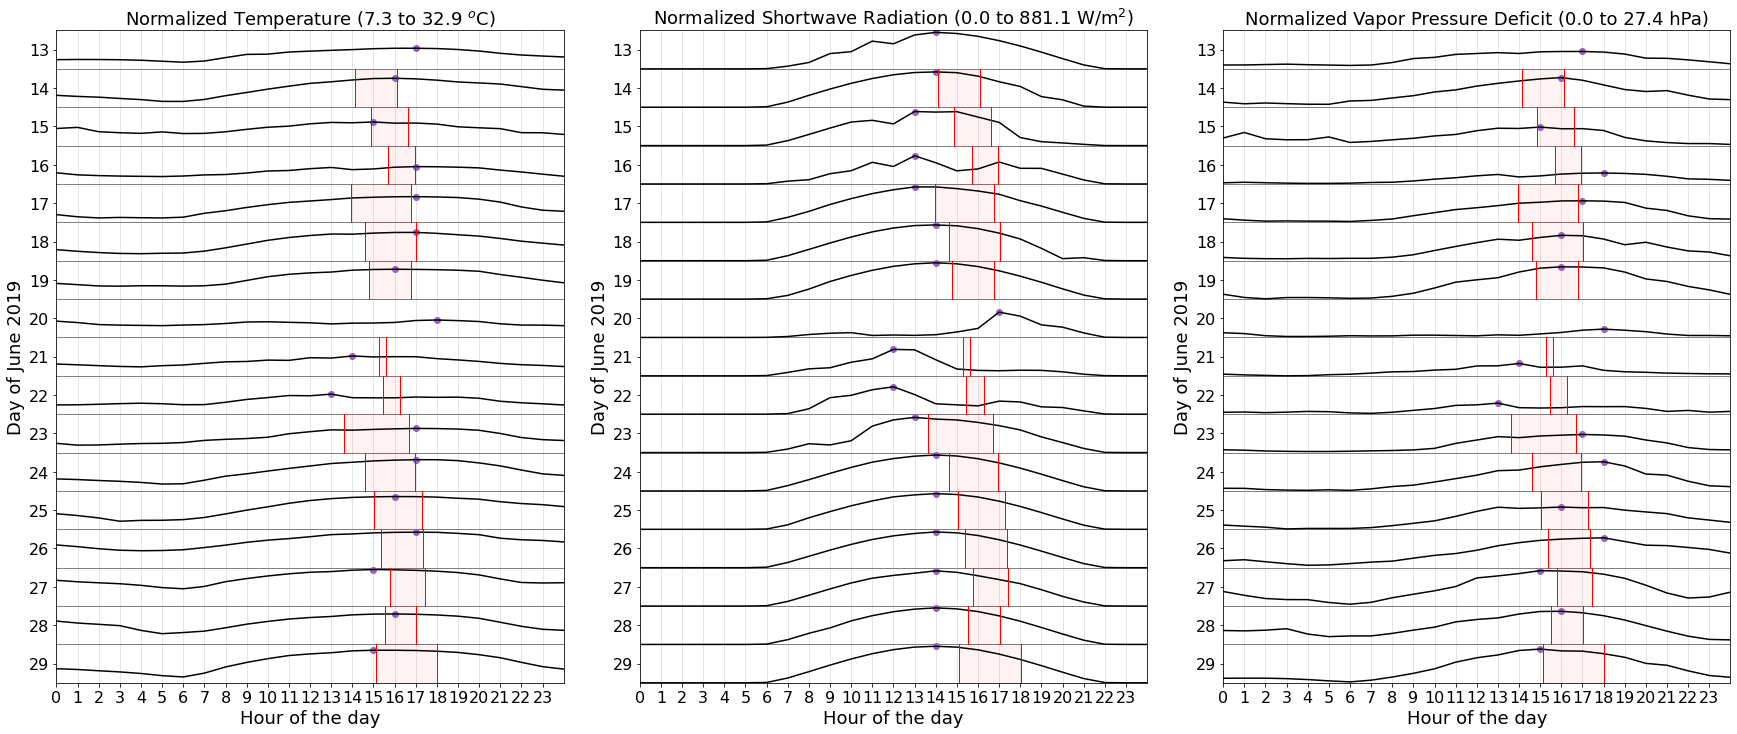

In [53]:

f,ax=plt.subplots(1,3,sharex=True,sharey=False)
f.set_size_inches(10*len(ax),12)
tpx = np.arange(0,24)

qnames = weather_per_hour.columns
titlelabels = ['Normalized Temperature','Normalized Shortwave Radiation','Normalized Vapor Pressure Deficit']#,'Wind speed']
units = ['$^o$C','W/m$^2$','hPa']#,'km/h']

maxhours = np.tile(np.nan,(len(titlelabels),len(daynumstoshow)))

for k, (titlelabel,qname) in enumerate(zip(titlelabels,qnames)):
    a=ax[k]
    y_perday = np.reshape(weather_per_hour[qname].values,(len(daystoload)+1,24))
    minval, maxval = np.min(y_perday), np.max(y_perday)
    title = titlelabel+' ('+str(np.round(minval,1))+' to '+str(np.round(maxval,1))+' '+units[k]+ ')'
    y_perday = (y_perday-minval)/(maxval-minval)

    yshift = 1.05
    yshifts=[]
    for ind,daynum in enumerate(daynumstoshow):
        i = np.where(daynum==daystoload)[0][0]
        offset=yshift*(24-i-1)
        yshifts.append(offset)
#         if k==0:
        a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
        a.plot(np.append(tpx,24),np.append(y_perday[i],y_perday[i+1,0])+offset,c='k')
        xmax = np.argmax(y_perday[i])
        a.scatter(xmax,y_perday[i][xmax]+offset,color=bp.snscolors[4])
        maxhours[k,ind] = xmax

    [a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
    a.set_xlim([0,24])
    a.tick_params(labelsize=16)
    a.set_xlim([0,24])
    #ticks
    a.set_xticks(np.arange(24))
    a.set_xticklabels(np.arange(24))
    a.set_yticks(np.array(yshifts)+yshift/2)
    a.set_yticklabels(daynumstoshow+junedaynumoffset)
    # title and labels
    a.set_title(title,fontsize=18)               
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)

    yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
    a.set_ylim([yshifts[-1],yshifts[0]])
    for i,act in enumerate(np.array(collectiveactivated)):
        ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
        act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
        if act[0]>0:
            a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
            a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
            a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)

            
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/weather-hourly.pdf')
plt.show()

## Other weather data
From this site, can download the open sources of weather data
https://meteostat.net/de/
It says that "per-hour" data is available for Konstanz, but in the online download interface, when choosing 2019, it only downloads per-day. (For recent times, e.g. last week, it downloads per-hour). Probably there is some way through the API to get the per-hour data but I didn't figure it out

In [54]:
# https://dev.meteostat.net/api/stations/daily.html#parameters
# tavg	The average air temperature in °C	Float
# tmin	The minimum air temperature in °C	Float
# tmax	The maximum air temperature in °C	Float
# prcp	The daily precipitation total in mm	Float
# snow	The maximum snow depth in mm	Integer
# wdir	The average wind direction in degrees (°)	Integer
# wspd	The average wind speed in km/h	Float
# wpgt	The peak wind gust in km/h	Float
# pres	The average sea-level air pressure in hPa	Float
# tsun	The daily sunshine total in minutes (m)	Integer

In [55]:
bd.alldaytimestamps[1]

Timestamp('2019-06-06 00:00:00', freq='D')

In [56]:
startind = 5
[o['date'][startind] for o in openweatherdata]

['2019-06-06', '2019-06-06', '2019-06-06', '2019-06-06', '2019-06-06']

In [57]:
# make tsun have units of hours instead
meteobluedaily['Konstanz-Litzelstetten Sunshine Duration'] = meteobluedaily['Konstanz-Litzelstetten Sunshine Duration']/60
for o in openweatherdata:
    o['tsun'] = o['tsun']/60

In [58]:
# add the averaged quantites abover to the meteobluedaily df
for q,w in zip(qnamestoaverage,weather_per_hour_averaged):
    meteobluedaily.loc[startind:,q] = w

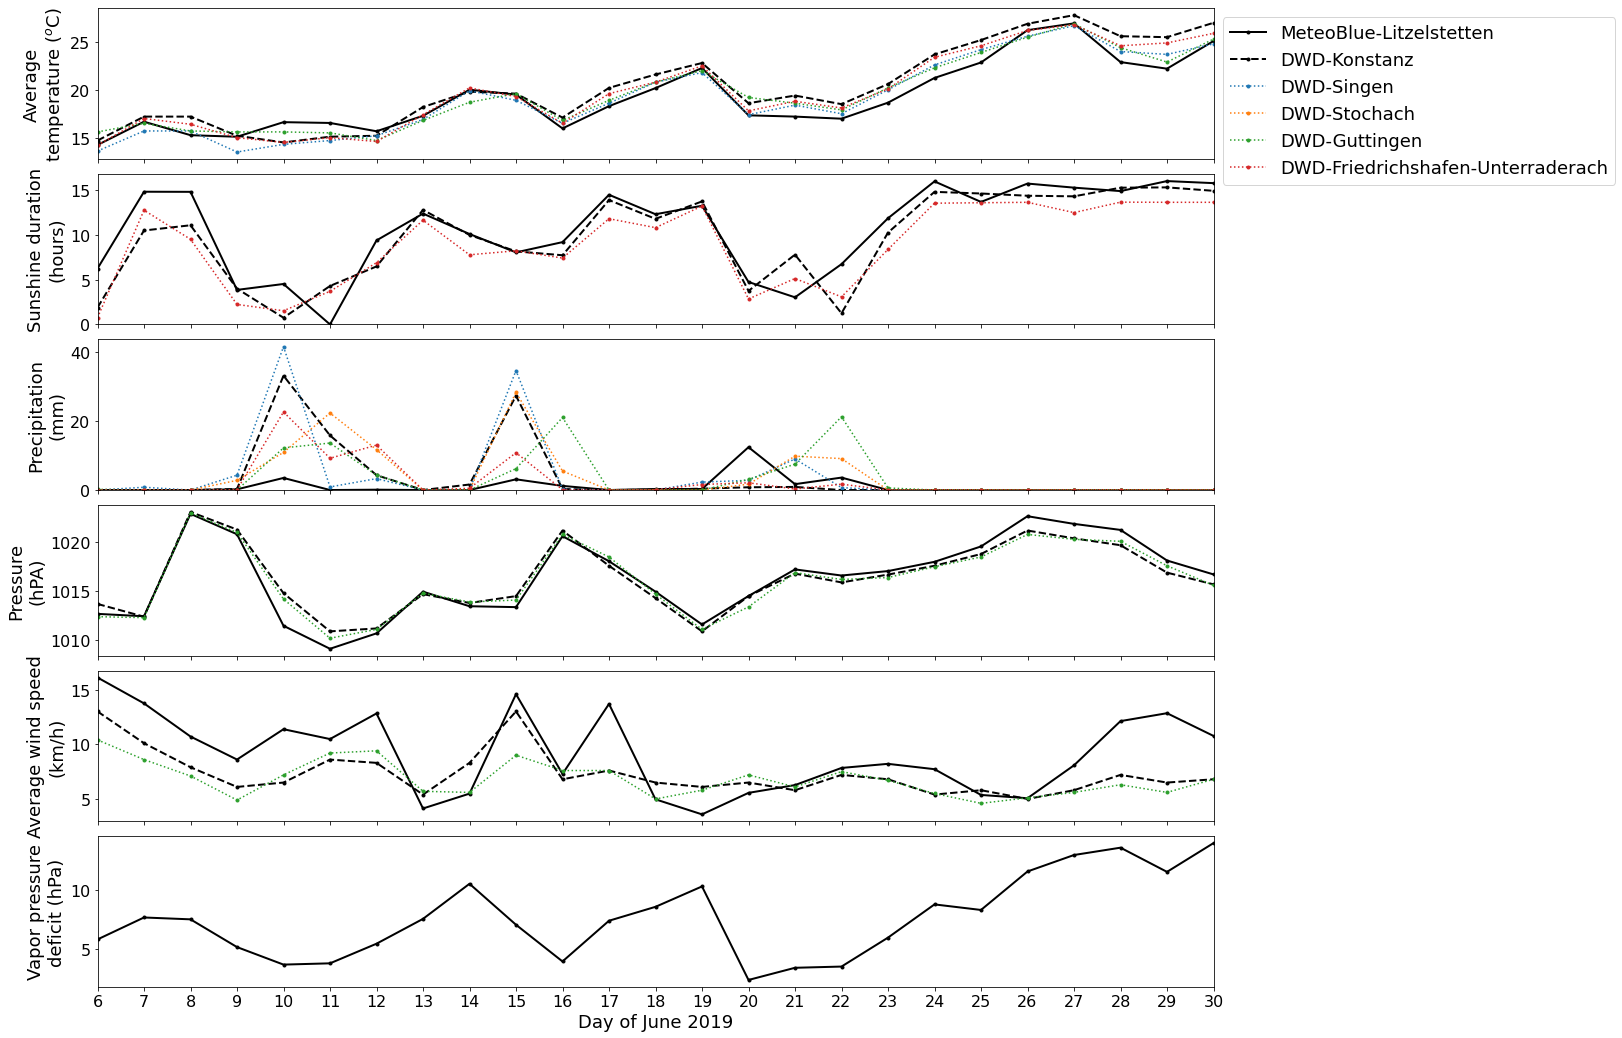

In [59]:
meteonames = ['Konstanz-Litzelstetten Temperature [2 m elevation corrected].2','Konstanz-Litzelstetten Sunshine Duration','Konstanz-Litzelstetten Precipitation Total'] + qnamestoaverage[0:2]
dwdnames = ['tavg','tsun','prcp','pres','wspd']
ylabels = ['Average\ntemperature ($^o$C)','Sunshine duration\n(hours)','Precipitation\n(mm)','Pressure\n(hPA)','Average wind speed\n(km/h)']

f,ax = plt.subplots(len(dwdnames)+1,1,sharex=True)
f.set_size_inches(20,3*len(ax))
tpx = np.arange(25)

for a, n, mn,ylabel in zip(ax,dwdnames,meteonames,ylabels):
    a.plot(tpx,meteobluedaily[mn][startind:startind+len(tpx)],c='k',linestyle='-',label='MeteoBlue-Litzelstetten',marker='.',linewidth=2)
    for i, (wname,data) in enumerate(zip(weathernames_label,openweatherdata)):
        tpy = data[n][startind:startind+len(tpx)]
        a.plot(tpx,tpy,marker='.',label=wname,c=('k' if i==0 else bp.snscolors[i-1]),linestyle=('--' if i==0 else ':'),linewidth=(2 if i==0 else 1.5))
    a.set_ylabel(ylabel,fontsize=18)

# plot VPD separate because its only for MeteoBlue:
a=ax[-1]
a.plot(tpx,meteobluedaily[qnamestoaverage[-1]][startind:startind+len(tpx)],c='k',linestyle='-',label='MeteoBlue-Litzelstetten',marker='.',linewidth=2)
a.set_ylabel('Vapor pressure\ndeficit (hPa)',fontsize=18)

for a in ax:
    a.tick_params(labelsize=16)
    a.set_xticks(tpx)
ax[-1].set_xticklabels(tpx+junedaynumoffset+1)  # setting this so that the first day is the day shown above 
ax[0].legend(fontsize=18,bbox_to_anchor=[1,1])
ax[0].set_xlim([0,24])
ax[-1].set_xlabel('Day of June 2019',fontsize=18)
plt.subplots_adjust(hspace=0.1)
ax[1].set_ylim(bottom=0)
ax[2].set_ylim(bottom=0)
plt.savefig('image-output/weather-daily.pdf')
plt.show()

## Weather comparison with Shared activation

In [60]:
bd.alldaytimestamps[daynumstoshow[0]]

Timestamp('2019-06-13 00:00:00', freq='D')

In [61]:
startind = 12
meteobluedaily['timestamp'][startind]

Timestamp('2019-06-13 00:00:00')

In [62]:
mb_tocompare = meteobluedaily[startind:startind+len(daynumstoshow)]

In [63]:
collactstarts = np.tile(np.nan,len(daynumstoshow))
collactdurations = np.tile(np.nan,len(daynumstoshow))
for i,act in enumerate(collectiveactivated):
    if act[0]>0:
        collactstarts[i] = act[0]*5/60  # assuming 5 minute divisions
        collactdurations[i] = (act[1]+1-act[0])*5/60 # include the end period

In [64]:
print('shared activation period duration, in minutes')
pd.DataFrame(([bd.alldaytimestamps[daynumstoshow],collactdurations*60]))

shared activation period duration, in minutes


0                    1                    2                    3   \
0 2019-06-13  2019-06-14 00:00:00  2019-06-15 00:00:00  2019-06-16 00:00:00   
1        NaT                115.0                100.0                 70.0   

                    4                    5                    6          7   \
0  2019-06-17 00:00:00  2019-06-18 00:00:00  2019-06-19 00:00:00 2019-06-20   
1                165.0                140.0                115.0        NaT   

                    8                    9                    10  \
0  2019-06-21 00:00:00  2019-06-22 00:00:00  2019-06-23 00:00:00   
1                 15.0                 45.0                180.0   

                    11                   12                   13  \
0  2019-06-24 00:00:00  2019-06-25 00:00:00  2019-06-26 00:00:00   
1                135.0                130.0                115.0   

                    14                   15                   16  
0  2019-06-27 00:00:00  2019-06-28 00:00:00  2019-06-29 00:00:00  
1                 95.0                 85.0                170.0

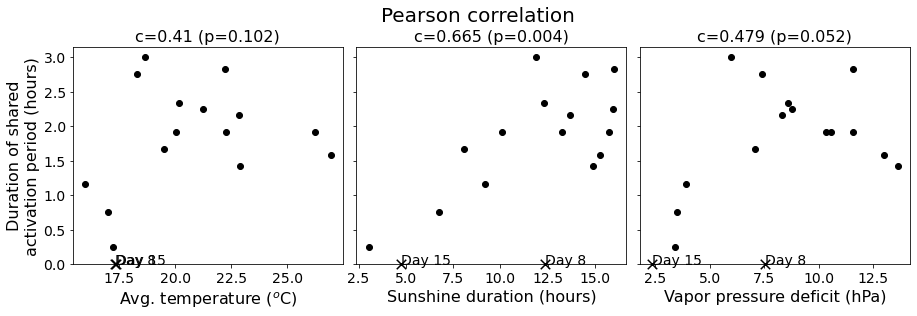

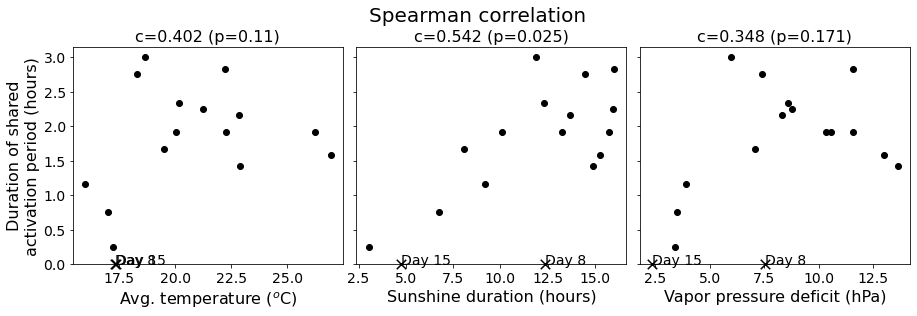

In [65]:
meteonames = ['Konstanz-Litzelstetten Temperature [2 m elevation corrected].2','Konstanz-Litzelstetten Sunshine Duration'] + [qnamestoaverage[-1]]

xlabels = ['Avg. temperature ($^o$C)','Sunshine duration (hours)','Vapor pressure deficit (hPa)']
for fn,testlabel in zip([scipy.stats.pearsonr,scipy.stats.spearmanr],['Pearson correlation','Spearman correlation']):
    f,ax = plt.subplots(1,3,sharey=True)
    f.set_size_inches(5*len(ax),4)

    noact = np.isnan(collactdurations)
    noactdaynums = daynumstoshow[noact]


    for j,m in enumerate(meteonames):
        a=ax[j]
        xtp = mb_tocompare[m]
        forcorr = collactdurations.copy()
        a.scatter(xtp,forcorr,c='k')
        forcorr[np.isnan(forcorr)] = 0
        corr, pvalue = fn(xtp,forcorr)
        a.set_title('c='+str(np.round(corr,3))+' (p='+str(np.round(pvalue,3))+')',fontsize=16)
        tpnoact=xtp[noact]
        a.scatter(tpnoact,np.zeros(np.sum(noact)),marker='x',s=90,c='k',clip_on=False)
        for i,x in enumerate(tpnoact):
            a.annotate('Day '+str(noactdaynums[i]), (x, 0),fontsize=14)
        a.set_xlabel(xlabels[j],fontsize=16)
    ax[0].set_ylabel('Duration of shared\nactivation period (hours)',fontsize=16)

    # # plt openDWD KN separate
    # a=ax[-1]
    # wind=0
    # tp = openweatherdata[wind]['prcp'][startind:startind+len(daynumstoshow)]
    # a.scatter(tp,collactdurations,c='k')
    # a.scatter(tp[noact],np.zeros(np.sum(noact)),marker='x',s=90,c='k',clip_on=False)
    # for i,x in enumerate(tp[noact]):
    #     a.annotate('Day '+str(noactdaynums[i]), (x, 0),fontsize=14)
    # a.set_xlabel('Precipitation-Konstanz (mm)',fontsize=16)

    for a in ax:
        a.tick_params(labelsize=14)
        a.set_ylim(bottom=0)
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(testlabel,y=1.02,fontsize=20)
    plt.savefig('image-output/weathercorr-'+testlabel+'.pdf')
    plt.show()

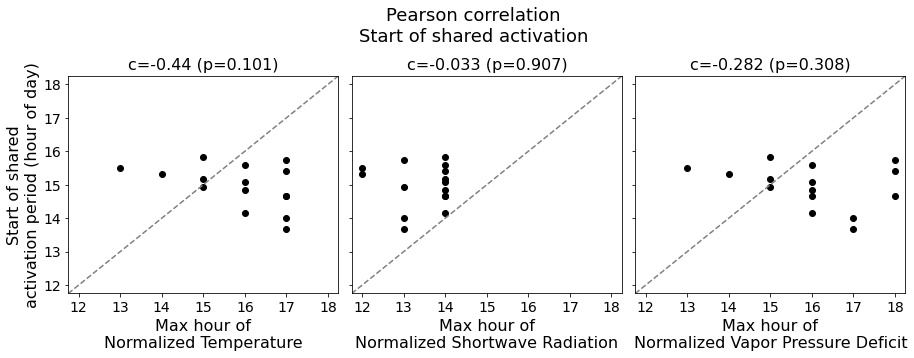

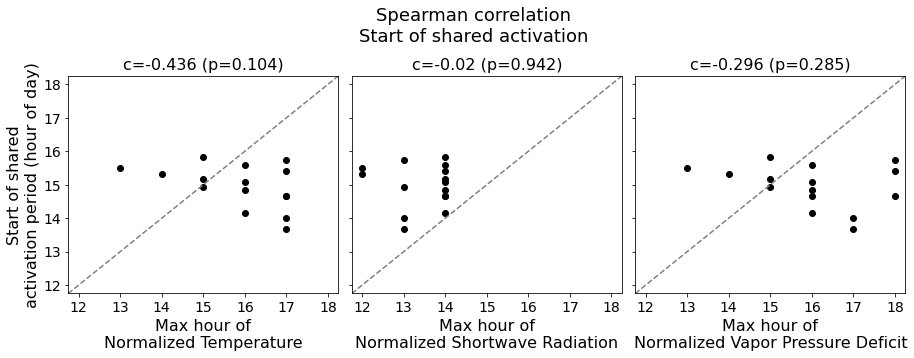

In [66]:
## Start of shared activation with peak times
meteonames = ['Konstanz-Litzelstetten Temperature [2 m elevation corrected].2','Konstanz-Litzelstetten Sunshine Duration'] + [qnamestoaverage[-1]]

xlabels = ['Avg. temperature ($^o$C)','Sunshine duration (hours)','Vapor pressure deficit (hPa)']

for fn,testlabel in zip([scipy.stats.pearsonr,scipy.stats.spearmanr],['Pearson correlation','Spearman correlation']):

    f,ax = plt.subplots(1,3,sharey=True,sharex=True)
    f.set_size_inches(5*len(ax),4)

    noact = np.isnan(collactdurations)
    noactdaynums = daynumstoshow[noact]


    for j,m in enumerate(titlelabels):
        a=ax[j]
        xtp = maxhours[j]
        forcorr = collactstarts.copy()
        a.scatter(xtp,forcorr,c='k')
    #     sns.regplot(xtp,forcorr,ax=a)
        corr, pvalue = fn(xtp[~noact],forcorr[~noact])
        a.set_title('c='+str(np.round(corr,3))+' (p='+str(np.round(pvalue,3))+')',fontsize=16)
    #     tpnoact=xtp[noact]
    #     a.scatter(tpnoact,np.zeros(np.sum(noact)),marker='x',s=90,c='k',clip_on=False)
    #     for i,x in enumerate(tpnoact):
    #         a.annotate('Day '+str(noactdaynums[i]), (x, 0),fontsize=14)
        a.set_xlabel('Max hour of\n'+m,fontsize=16)
    ax[0].set_ylabel('Start of shared\nactivation period (hour of day)',fontsize=16)

    for a in ax:
        a.tick_params(labelsize=14)
    #     a.set_ylim(bottom=0)
        a.set_xlim([11.75,18.25])
        a.set_ylim([11.75,18.25])
        a.set_xticks(np.arange(12,19))
        a.set_yticks(np.arange(12,19))    
        x=np.arange(11,20)
        a.plot(x,x,c='grey',linestyle='--')
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(testlabel+'\n'+'Start of shared activation',fontsize=18,y=1.12)
    plt.savefig('image-output/weathercorr-start-'+testlabel+'.pdf')
    plt.show()
    

# (Supp) Number of trips and duration of trip

In [67]:

all_trips_per_indiv = []
all_length_per_trip = []
i=1
for i in range(len(collectiveactivated)):
    act = collectiveactivated[i]
    indivdata = daylist_outside[i].values[:,act[0]:act[1]+1]

    diffs = np.diff(indivdata,axis=1)
    # trips per individual:  went outside (0 to 1) OR was outside at the start (started at 1)
    if act[0]>0:
        trips_per_indiv = np.sum(diffs==1,axis=1) + (indivdata[:,0]==1)
    else:
        trips_per_indiv = np.array([])
    # time per trip:
    # Special cases:
    ## start is 1:  then remove the first -1
    ## end is 1: then remove the last 1
    length_per_trip = [[]]
    if act[0]>0:
        for count, (indiv,d) in enumerate(zip(indivdata,diffs)):
            w_on = np.where(d==1)[0]
            w_off = np.where(d==-1)[0]
            if indiv[0]==1:
                w_off = w_off[1:]
            if indiv[-1]==1:
                w_on = w_on[0:-1]
            if not(len(w_on)==len(w_off)):
                print(count)
            if not(np.all(w_on<w_off)):
                print('oops',count)
            length_per_trip.append(w_off-w_on)
    all_trips_per_indiv.append(trips_per_indiv)
    all_length_per_trip.append(np.concatenate(length_per_trip))

Mean trips per indiv: 1.17 +/- 1.05
1.6802486187845305
Mean trip length (minutes): 24.2 +/- 11.6


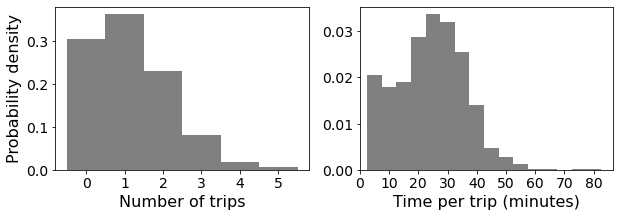

In [68]:
f,ax = plt.subplots(1,2)
f.set_size_inches(10,3)
a=ax[0]
tp = np.concatenate(all_trips_per_indiv)
print('Mean trips per indiv:',np.round(np.mean(tp),2),'+/-',np.round(np.std(tp),2))
print(np.mean(tp[tp>0]))
a.hist(tp,density=True,bins=np.arange(-0.5,np.max(tp)+1.5),color='grey')
a.set_xticks(np.arange(6))
a.set_xlabel('Number of trips',fontsize=16)
a=ax[1]
tp = np.concatenate(all_length_per_trip)
bins = np.arange(-0.5,np.max(tp)+1.5)
tp, bins = tp*5, bins*5  #convert timebins to minutes
print('Mean trip length (minutes):',np.round(np.mean(tp),1),'+/-',np.round(np.std(tp),1))
a.hist(tp,density=True,color='grey',bins=bins)
a.set_xticks(np.arange(0,90,10))
a.set_xlim(left=0)
a.set_xlabel('Time per trip (minutes)',fontsize=16)
ax[0].set_ylabel('Probability density',fontsize=16)
[a.tick_params(labelsize=14) for a in ax]
plt.savefig('image-output/numtrips-hists.pdf')
plt.show()

# (Supp) Movement of workers

In [69]:
colnums = [np.where(df.columns=='Median speed')[0][0]] #,np.where(df.columns=='Dispersion (avg)')[0][0]]
colnums

[13]

In [70]:
obs_threshold=10 / (3*60*5) # I had converted to fraction of 5 min period fully tracked, so make this instead.  This is very low
substratefrac_threshold=0.5
substratename='Frame 5'

toplotaveragevalues = np.tile(np.nan,(len(colnums),len(daynumstoshow),numtimedivs))
for i,daynum in enumerate(daynumstoshow):
    dfday = df[(df['Day number']==daynum)&np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))]
    day_uids, day_ages, all_onsubstrate, bee_obs, bee_data = dfunc.get_onsubstrate(dfday, obs_threshold, substratefrac_threshold, substratename=substratename,numtimedivs=numtimedivs)

    for k,colnum in enumerate(colnums):
        to_average = bee_data[:,:,colnum]
        to_average[all_onsubstrate==0] = np.nan
        to_average[bee_obs<obs_threshold] = np.nan        
        toplotaveragevalues[k,i] = np.nanmean(to_average,axis=0)

    # toplotaveragevalues.append(np.nanmean(to_average,axis=0))

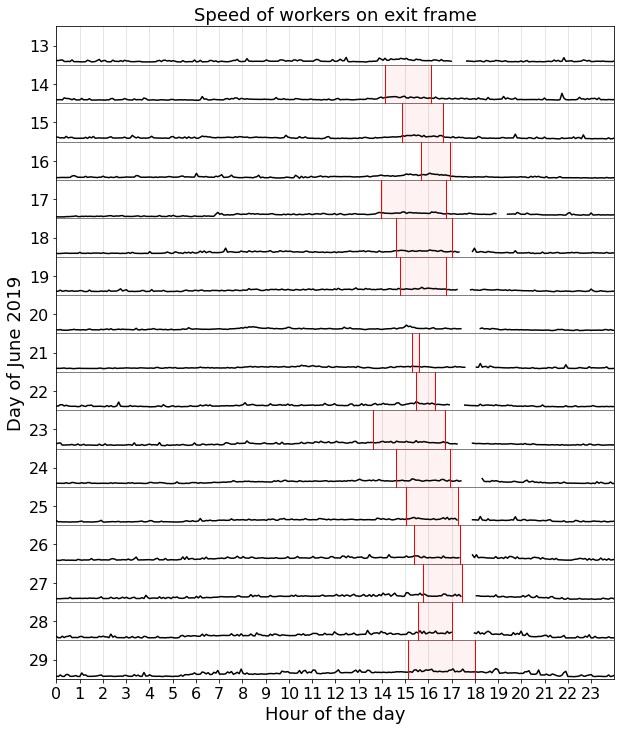

In [71]:

f,ax=plt.subplots(1,1,sharex=True,sharey=False)
f.set_size_inches(10*len(colnums),12)

tpx = np.linspace(0,24,numtimedivs)

# for k in range(len(colnums)):
k=0
a=ax
y_perday = np.array(toplotaveragevalues[k].copy())
# don't normalized like the weather data - set explicit values
#     minval, maxval = np.nanmin(y_perday), np.nanmax(y_perday)
#     title = titlelabel+' ('+str(np.round(minval,1))+' to '+str(np.round(maxval,1))+' '+units[k]+ ')'
#     y_perday = (y_perday-minval)/(maxval-minval)

yshift = [2.5,7][k] #1.05
yshifts=[]
for i,daynum in enumerate(daynumstoshow):
    offset=yshift*(len(daynumstoshow)-i-1)
    yshifts.append(offset)
#         if k==0:
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    a.plot(tpx,y_perday[i]+offset,c='k')


[a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
a.set_xlim([0,24])
a.tick_params(labelsize=16)
a.set_xlim([0,24])
#ticks
a.set_xticks(np.arange(24))
a.set_xticklabels(np.arange(24))
a.set_yticks(np.array(yshifts)+yshift/2)
a.set_yticklabels(daynumstoshow+junedaynumoffset)
# title and labels
a.set_xlabel('Hour of the day',fontsize=18)
a.set_ylabel('Day of June 2019',fontsize=18)

yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
a.set_ylim([yshifts[-1],yshifts[0]])
for i,act in enumerate(np.array(collectiveactivated)):
    ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
    act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
    if act[0]>0:
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
        a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)


ax.set_title('Speed of workers on exit frame',fontsize=18)            
# ax[1].set_title('Dispersion of workers on exit frame',fontsize=18)               

        
        
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/workers-on-exit-frame-hourly.pdf')
plt.show()

### All workers

In [72]:
obs_threshold=10 / (3*60*5) # I had converted to fraction of 5 min period fully tracked, so make this instead.  This is very low
substratefrac_threshold=0.25
substratename='Frame 5'

toplotaveragevalues = np.tile(np.nan,(len(colnums),len(daynumstoshow),numtimedivs))
for i,daynum in enumerate(daynumstoshow):
    dfday = df[(df['Day number']==daynum)&np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))]
    day_uids, day_ages, all_onsubstrate, bee_obs, bee_data = dfunc.get_onsubstrate(dfday, obs_threshold, substratefrac_threshold, substratename=substratename,numtimedivs=numtimedivs)

    for k,colnum in enumerate(colnums):
        to_average = bee_data[:,:,colnum]
        # to_average[all_onsubstrate==0] = np.nan
        to_average[bee_obs<obs_threshold] = np.nan
        toplotaveragevalues[k,i] = np.nanmean(to_average,axis=0)

    # toplotaveragevalues.append(np.nanmean(to_average,axis=0))

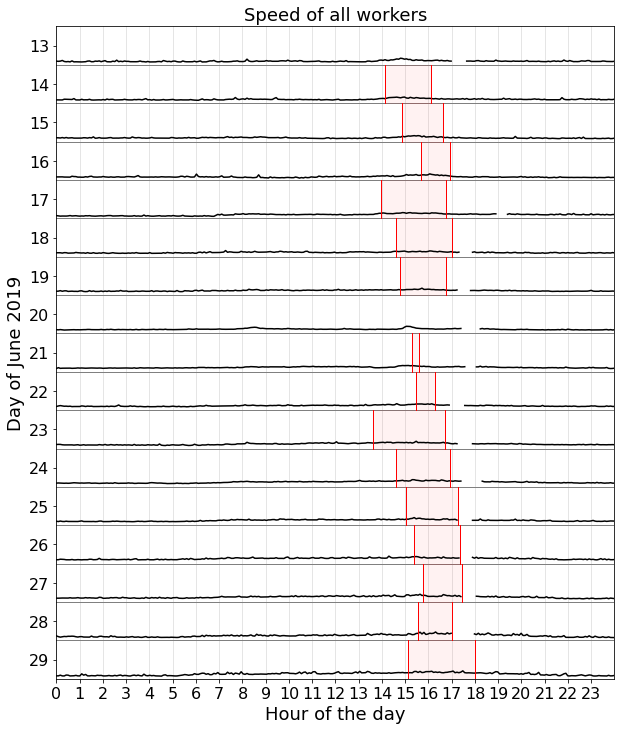

In [73]:

f,ax=plt.subplots(1,1,sharex=True,sharey=False)
f.set_size_inches(10*len(colnums),12)

tpx = np.linspace(0,24,numtimedivs)

# for k in range(len(colnums)):
k=0
a=ax
y_perday = np.array(toplotaveragevalues[k].copy())
# don't normalized like the weather data - set explicit values
#     minval, maxval = np.nanmin(y_perday), np.nanmax(y_perday)
#     title = titlelabel+' ('+str(np.round(minval,1))+' to '+str(np.round(maxval,1))+' '+units[k]+ ')'
#     y_perday = (y_perday-minval)/(maxval-minval)

yshift = [2.5,7][k] #1.05
yshifts=[]
for i,daynum in enumerate(daynumstoshow):
    offset=yshift*(len(daynumstoshow)-i-1)
    yshifts.append(offset)
#         if k==0:
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    a.plot(tpx,y_perday[i]+offset,c='k')


[a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
a.set_xlim([0,24])
a.tick_params(labelsize=16)
a.set_xlim([0,24])
#ticks
a.set_xticks(np.arange(24))
a.set_xticklabels(np.arange(24))
a.set_yticks(np.array(yshifts)+yshift/2)
a.set_yticklabels(daynumstoshow+junedaynumoffset)
# title and labels
a.set_xlabel('Hour of the day',fontsize=18)
a.set_ylabel('Day of June 2019',fontsize=18)

yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
a.set_ylim([yshifts[-1],yshifts[0]])
for i,act in enumerate(np.array(collectiveactivated)):
    ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
    act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
    if act[0]>0:
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
        a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)


ax.set_title('Speed of all workers',fontsize=18)            
# ax[1].set_title('Dispersion of workers on exit frame',fontsize=18)               

        
        
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/workers-all-hourly.pdf')
plt.show()

# (Extra) Statistical and related calculations

In [74]:
printmeanstd = lambda vals: print(np.round(np.nanmean(vals),3),'+/-',np.round(np.nanstd(vals),3))
notnansel = lambda x: x[np.logical_not(np.isnan(x))]

In [75]:
# add a column for day and timedivision, for easier time selection
df['Day+Time'] = df['Day number']*numtimedivs + df['timedivision']

## Drone vs worker speed over the whole observation period

In [76]:
perdronespeed = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))].pivot(index="Bee unique ID",columns='Day+Time', values='Median speed')
perworkerspeed = df[((df['Cohort ID']==7)|(df['Cohort ID']==9))].pivot(index="Bee unique ID",columns='Day+Time', values='Median speed')

In [77]:
## Overall mean and standard deviation
dvals = notnansel(perdronespeed.values.flatten())
wvals = notnansel(perworkerspeed.values.flatten())
print('Overall drone mean speed during entire period:')
printmeanstd(dvals)
print('Overall worker mean speed during entire period:')
printmeanstd(wvals)

print(scipy.stats.ttest_ind(notnansel(dvals),notnansel(wvals),equal_var=False))

Overall drone mean speed during entire period:
0.079 +/- 0.176
Overall worker mean speed during entire period:
0.271 +/- 0.178
Ttest_indResult(statistic=-836.5801525354693, pvalue=0.0)


In [78]:
## Per-individual mean and standard deviation
dvals = notnansel(np.nanmean(perdronespeed,axis=1))
wvals = notnansel(np.nanmean(perworkerspeed,axis=1))
print('Per-Drone mean speed during entire period:',len(dvals),'drones')
printmeanstd(dvals)
print('Per-Worker mean speed during entire period:',len(wvals),'workers')
printmeanstd(wvals)

print(scipy.stats.ttest_ind(dvals,wvals,equal_var=False))

Per-Drone mean speed during entire period: 190 drones
0.08 +/- 0.027
Per-Worker mean speed during entire period: 736 workers
0.262 +/- 0.035
Ttest_indResult(statistic=-76.66107403950997, pvalue=7.242894349478971e-227)


## Drone vs worker mean speed during activation period

In [79]:
# first, make a selector mask, so that can use the above per-drone lists
actseldf = pd.DataFrame(index=perdronespeed.columns)
actseldf['during activation period'] = False
for i,daynum in enumerate(daynumstoshow):
    act = collectiveactivated[i]
    actstart = daynum*numtimedivs + act[0]
    actend = daynum*numtimedivs + act[1]
    actinds = np.arange(actstart,actend+1)
    if len(actinds)>1:
        actseldf.loc[actinds,'during activation period'] = True

In [80]:
## During activation period, Overall mean and standard deviation
dvals = (perdronespeed[actseldf.loc[actseldf['during activation period']==True].index]).values.flatten()
wvals = (perworkerspeed[actseldf.loc[actseldf['during activation period']==True].index]).values.flatten()
print('Per-Drone mean speed during activation period:')
printmeanstd(dvals)
print('Per-Worker mean speed during activation period:')
printmeanstd(wvals)

print(scipy.stats.ttest_ind(notnansel(dvals),notnansel(wvals),equal_var=False))

Per-Drone mean speed during activation period:
0.743 +/- 0.684
Per-Worker mean speed during activation period:
0.371 +/- 0.213
Ttest_indResult(statistic=72.72865065232058, pvalue=0.0)


In [81]:
## During activation period, Per-individual mean and standard deviation
dvals = notnansel(np.nanmean(perdronespeed[actseldf.loc[actseldf['during activation period']==True].index],axis=1))
wvals = notnansel(np.nanmean(perworkerspeed[actseldf.loc[actseldf['during activation period']==True].index],axis=1))
print('Per-Drone mean speed during activation period:',len(dvals),'drones')
printmeanstd(dvals)
print('Per-Worker mean speed during activation period:',len(wvals),'workers')
printmeanstd(wvals)

print(scipy.stats.ttest_ind(dvals,wvals,equal_var=False))

Per-Drone mean speed during activation period: 170 drones
0.779 +/- 0.282
Per-Worker mean speed during activation period: 704 workers
0.355 +/- 0.068
Ttest_indResult(statistic=19.406975327201014, pvalue=2.2826285842872175e-45)
